### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import os
import zipfile
import keras as ker
import seaborn as sns
import glob

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
zipped_file = os.getenv("ziped_file")
sesnor_data = os.getenv("folder_name")
output_dir = os.getenv('sensor_heatmaps')
video_output = os.getenv('temperature_output')

In [3]:
def extract_zip(file_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)

    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    
    print(f'Files extracted to {extract_to}')

In [4]:
extract_zip(zipped_file, sesnor_data)

Files extracted to Sensor_data


In [5]:
def extract_data_from_sheet(df):
    sensor_name = df.iloc[0, 1]

    extracted_df = df.iloc[3:].reset_index(drop=True)

    extracted_df.columns = ['Time', 'Temperature', 'Humidity']
    extracted_df['Time'] = pd.to_datetime(extracted_df['Time'], format='%d-%m-%Y %H:%M')
    
    extracted_df['Sensor Info'] = sensor_name

    return extracted_df

In [6]:
def split_sensor_info(sensor_info):
    parts = sensor_info.split(' ')
    return pd.Series([parts[0], sensor_info])

In [7]:
def read_all_excel_files(directory):
    excel_files = glob.glob(os.path.join(directory, '**', '*.xlsx*'), recursive=True)
    data_frames = []

    for file in excel_files:
        print(f'Reading file: {file}')
        # Read each sheet in the Excel file
        xls = pd.ExcelFile(file)
        for sheet_name in xls.sheet_names:
            df = pd.read_excel(file, sheet_name=sheet_name)
            extracted_df = extract_data_from_sheet(df)
            data_frames.append(extracted_df)

    # Combine all DataFrames
    combined_data = pd.concat(data_frames, ignore_index=True)

    # Apply the split_sensor_info function
    combined_data[['Sensor ID', 'Sensor Name']] = combined_data['Sensor Info'].apply(split_sensor_info)

    return combined_data

In [8]:
combined_data = read_all_excel_files(sesnor_data)

Reading file: Sensor_data\Data17052024-210552024\Sensor data[0474D,04750,04754,04756,04757,0475A,0475C,0475D,04762,04763,04765,04768,0476E,04771,04773,0477F,04787,04789,0478A,0478C](01_01_2024-20_05_2024) (1).xlsx
Reading file: Sensor_data\Data17052024-210552024\Sensor data[0478E,04791,04792,04796,0479B,0479D,0479E,047A8,047AA,047AD,047B2,047B6,047B7,047B8,047BA,047BB,047BC,047C1](01_01_2024-20_05_2024).xlsx
Reading file: Sensor_data\Data17052024-210552024\Sensor data[047C2,047C4,047C5,047C7,047C8,047C9,047CA,047CB,047CD,047CE,047D2,047D3,047D4,047D6,047D7,047DD,047F7,04802,04804,0480E](01_01_2024-20_05_2024).xlsx


In [9]:
combined_data.head()

Time Temperature Humidity      Sensor Info Sensor ID  \
0 2024-04-16 13:09:53       21.95     50.3  0474D T/RH IP67     0474D   
1 2024-04-16 13:14:52        22.5     34.7  0474D T/RH IP67     0474D   
2 2024-04-16 13:19:54       24.05     34.7  0474D T/RH IP67     0474D   
3 2024-04-16 13:24:53       24.25     34.7  0474D T/RH IP67     0474D   
4 2024-04-16 13:29:52       24.15     35.2  0474D T/RH IP67     0474D   

       Sensor Name  
0  0474D T/RH IP67  
1  0474D T/RH IP67  
2  0474D T/RH IP67  
3  0474D T/RH IP67  
4  0474D T/RH IP67

In [10]:
combined_data = combined_data.drop_duplicates(subset=['Time', 'Sensor ID'])

In [11]:
combined_data = combined_data.drop('Sensor Info',axis=1)

In [12]:
combined_data.isnull().sum()

Time              0
Temperature    9881
Humidity       9881
Sensor ID         0
Sensor Name       0
dtype: int64

In [13]:
sample_dataset = combined_data.copy()

In [14]:
sample_dataset = sample_dataset[['Time','Temperature','Sensor ID']]

In [15]:
sample_dataset.head()

Time Temperature Sensor ID
0 2024-04-16 13:09:53       21.95     0474D
1 2024-04-16 13:14:52        22.5     0474D
2 2024-04-16 13:19:54       24.05     0474D
3 2024-04-16 13:24:53       24.25     0474D
4 2024-04-16 13:29:52       24.15     0474D

In [16]:
sample_dataset['Temperature'] = sample_dataset['Temperature'].astype('float')

In [17]:
sensor_ids = sample_dataset['Sensor ID'].unique()
size_x = 5
size_y = 4

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

frames = []
for sensor_id in sensor_ids:
    sensor_data = sample_dataset[sample_dataset['Sensor ID'] == sensor_id].reset_index(drop=True)

    temperature_grid = np.zeros((size_x, size_y))

    for index, row in sensor_data.iterrows():
        x = index % size_x
        y = index // size_x
        if x < size_x and y < size_y:
            temperature_grid[x, y] = row['Temperature']

    plt.figure(figsize=(10, 6))
    sns.heatmap(temperature_grid, cmap='hot', cbar_kws={'label': 'Temperature (°C)'}, fmt=".2f", xticklabels=False, yticklabels=False,cbar=False)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    output_file = os.path.join(output_dir, f"heatmap_{sensor_id}.png")
    plt.savefig(output_file)
    plt.close()

    frames.append(output_file)

print(f"Heat maps saved in the directory: {output_dir}")

Heat maps saved in the directory: sensor_heatmaps


In [18]:
frame = cv2.imread(frames[0])
height, width, _ = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video = cv2.VideoWriter(video_output, fourcc, 5.0, (width, height))

prev_frame = cv2.imread(frames[0])

for frame_path in frames[1:]:
    next_frame = cv2.imread(frame_path)
    
    for i in range(1, 10):
        alpha = i / 10.0
        interpolated_frame = cv2.addWeighted(prev_frame, 1 - alpha, next_frame, alpha, 0)
        video.write(interpolated_frame)

    prev_frame = next_frame

video.release()
cv2.destroyAllWindows()

print(f"Video saved as: {video_output}")

Video saved as: sensor_heatmaps_temperature_video.avi


In [19]:
combined_data['Humidity'] = combined_data['Humidity'].astype('float')
combined_data['Temperature'] = combined_data['Temperature'].astype('float')

In [20]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        current_data_slice = data[i-n_steps:i]
        if not np.isnan(data[i]) and np.isnan(current_data_slice).any():
            X.append(current_data_slice)
            y.append(data[i])
    return np.array(X), np.array(y)

In [21]:
def build_model(input_shape):
    model = ker.models.Sequential([
        ker.layers.Input(shape=input_shape),
        ker.layers.Dense(256, activation='relu', kernel_regularizer=ker.regularizers.l2(0.001)),
        ker.layers.Dropout(0.3),
        ker.layers.Dense(128, activation='relu', kernel_regularizer=ker.regularizers.l2(0.001)),
        ker.layers.Dropout(0.3),
        ker.layers.Dense(64, activation='relu', kernel_regularizer=ker.regularizers.l2(0.001)),
        ker.layers.Dropout(0.3),
        ker.layers.Dense(32, activation='relu', kernel_regularizer=ker.regularizers.l2(0.001)),
        ker.layers.Dropout(0.3),
        ker.layers.Dense(1)
    ])
    model.compile(optimizer=ker.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

In [22]:
def fill_missing_values(data, model, feature_name, n_steps):
    data_copy = data.copy()
    feature_data = data_copy[feature_name].values
    for i in range(n_steps, len(feature_data)):
        if np.isnan(feature_data[i]):
            if np.isnan(feature_data[i-n_steps:i]).any():
                continue
            X_input = feature_data[i-n_steps:i].reshape(1, -1)
            predicted_value = model.predict(X_input, verbose=0)
            feature_data[i] = np.round(predicted_value.item(), 2)
    data_copy[feature_name] = feature_data
    return data_copy

In [23]:
def train_and_fill(data, feature_name, n_steps):
    feature_data = data[feature_name].values
    X, y = create_sequences(feature_data, n_steps)
    input_shape = (X.shape[1],)
    print(input_shape)
    model = build_model(input_shape)
    model.fit(X, y, epochs=50, batch_size=32, validation_split=0.3)
    filled_data = fill_missing_values(data, model, feature_name, n_steps)
    return filled_data

In [24]:
if combined_data['Temperature'].isnull().sum() > 0 or combined_data['Humidity'].isnull().sum() > 0:
    if combined_data['Temperature'].isnull().sum() > 0:
        combined_data = train_and_fill(combined_data, 'Temperature', 10)
    if combined_data['Humidity'].isnull().sum() > 0:
        combined_data = train_and_fill(combined_data, 'Humidity', 10)
else:
    print('No null values detected!!!!!!')

(10,)
Epoch 1/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 2/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - val_loss: nan
Epoch 3/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - val_loss: nan
Epoch 4/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - val_loss: nan
Epoch 5/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - val_loss: nan
Epoch 6/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - val_loss: nan
Epoch 7/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - val_loss: nan
Epoch 8/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - val_loss: nan
Epoch 9/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - val_loss: nan
Epoch 10/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - val_loss: nan
Epoch 11/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - val_loss: nan
Epoch 12/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - val_loss: nan
Epoch 13/50
619/619 ━━━━━━━━━━━

In [25]:
final_dataset = combined_data.dropna()

In [26]:
final_dataset.head()

Time  Temperature  Humidity Sensor ID      Sensor Name
0 2024-04-16 13:09:53        21.95      50.3     0474D  0474D T/RH IP67
1 2024-04-16 13:14:52        22.50      34.7     0474D  0474D T/RH IP67
2 2024-04-16 13:19:54        24.05      34.7     0474D  0474D T/RH IP67
3 2024-04-16 13:24:53        24.25      34.7     0474D  0474D T/RH IP67
4 2024-04-16 13:29:52        24.15      35.2     0474D  0474D T/RH IP67

In [27]:
def detect_anomalies(sensor_data, sensor_id):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    for ax, column in zip(axes, ['Temperature', 'Humidity']):
        mean = sensor_data[column].mean()
        std_dev = sensor_data[column].std()
        lower_bound = mean - 2 * std_dev
        upper_bound = mean + 2 * std_dev
        
        sensor_data[f'{column}_anomaly'] = np.where(
            (sensor_data[column] < lower_bound) | (sensor_data[column] > upper_bound), 1, 0)
        
        ax.hist(sensor_data[column], bins=30, alpha=0.6, color='g', density=True)
        
        x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
        p = (1/(std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
        ax.plot(x, p, 'k', linewidth=2)
        
        anomalies = sensor_data[sensor_data[f'{column}_anomaly'] == 1]
        ax.scatter(anomalies[column], np.zeros(len(anomalies)), color='r')
        
        ax.set_title(f'Normal Distribution of {column} for Sensor {sensor_id}')
        ax.set_xlabel(column)
        ax.set_ylabel('Density')
        ax.axvline(x=lower_bound, color='b', linestyle='--', label='Lower 2-Sigma')
        ax.axvline(x=upper_bound, color='b', linestyle='--', label='Upper 2-Sigma')
        ax.legend()

    plt.tight_layout()
    plt.show()
    
    return sensor_data

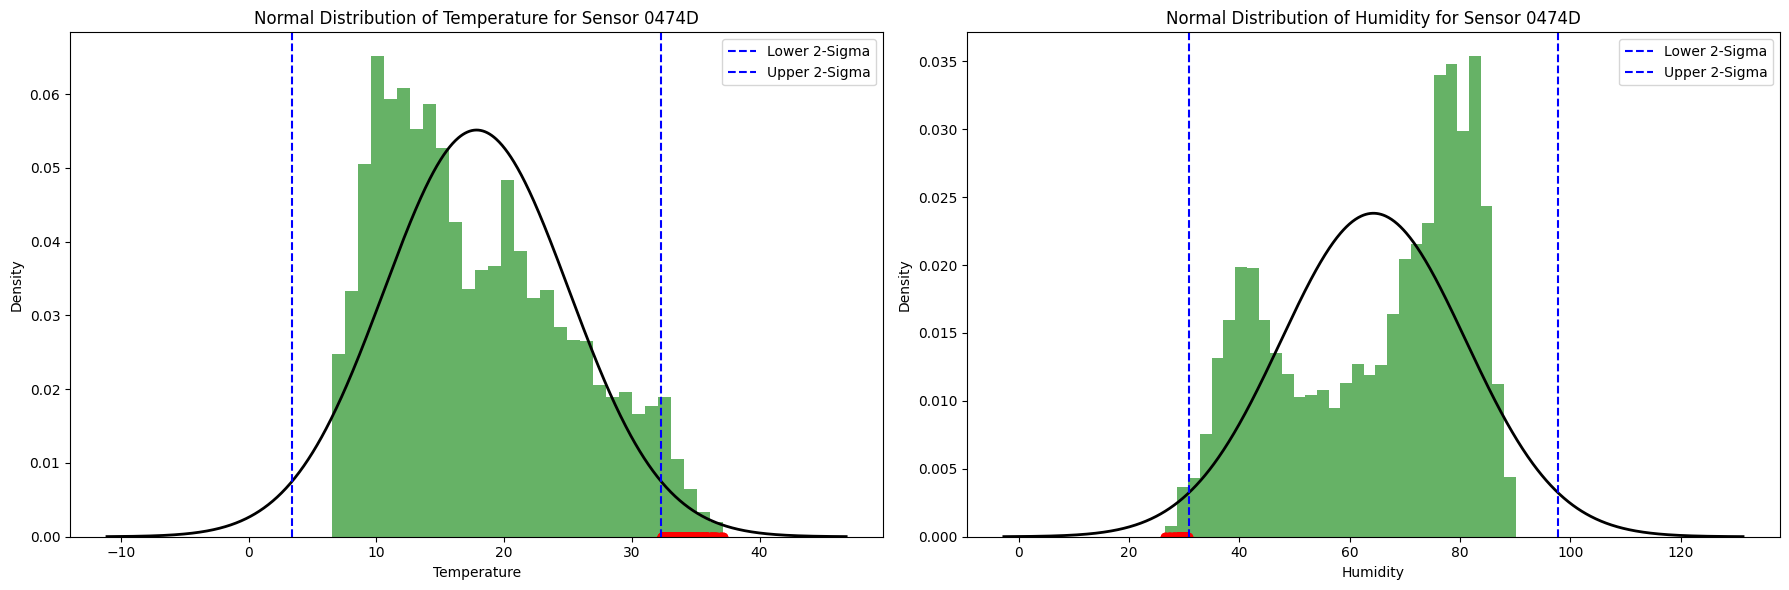

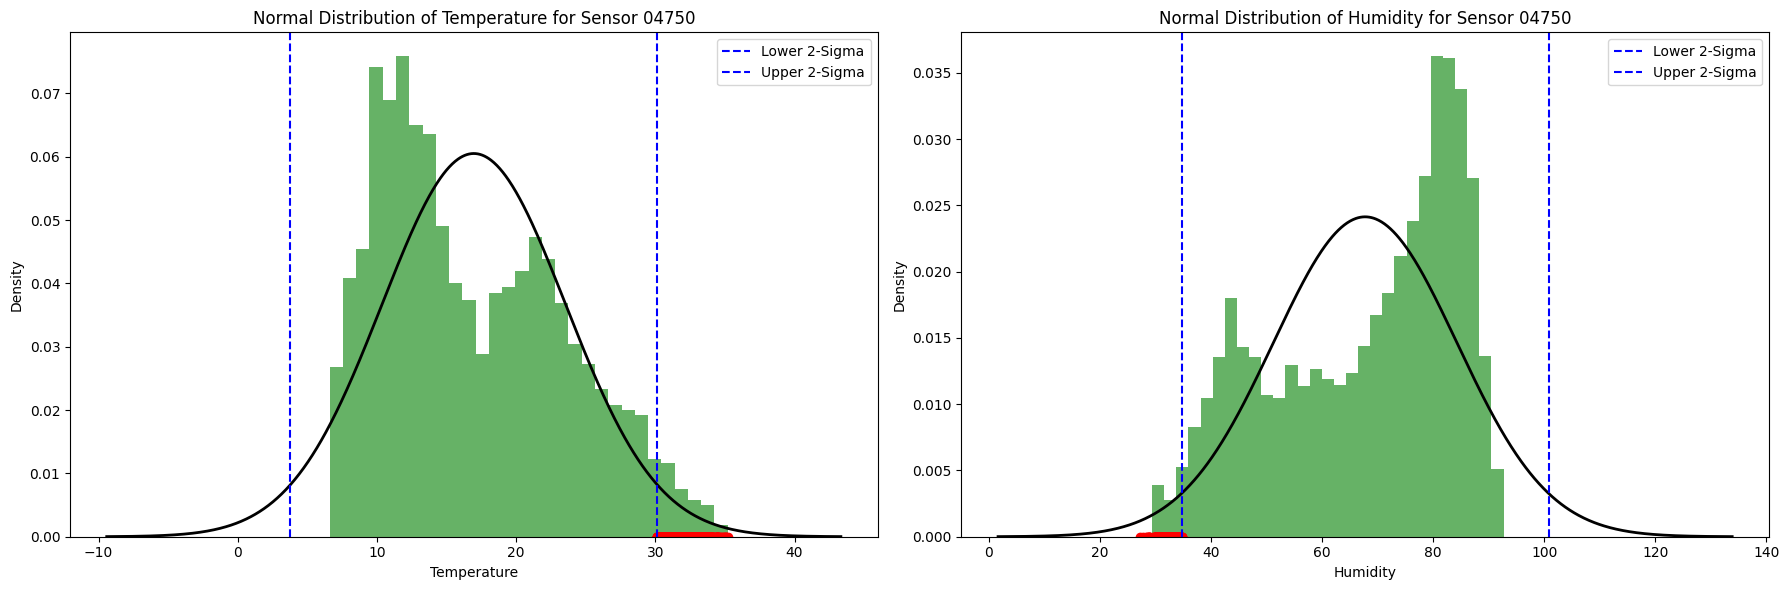

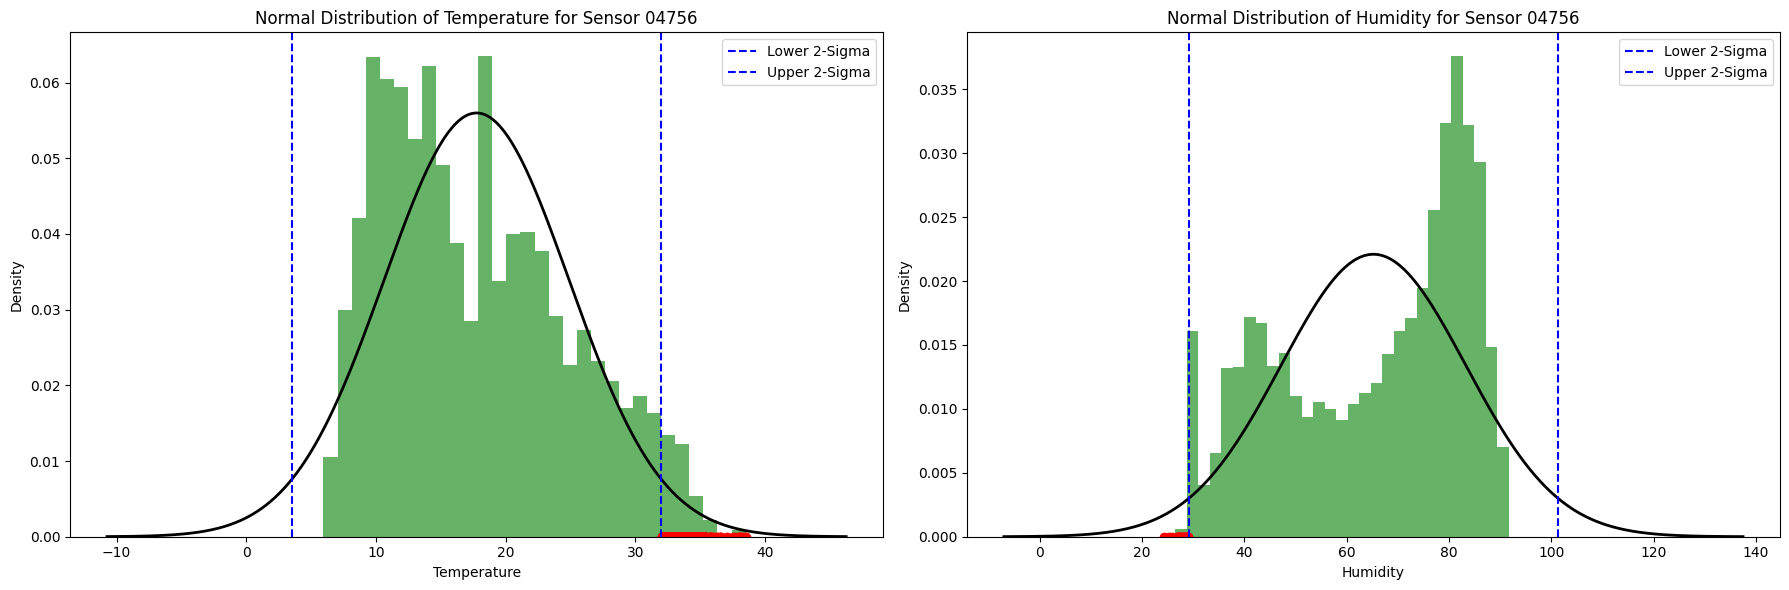

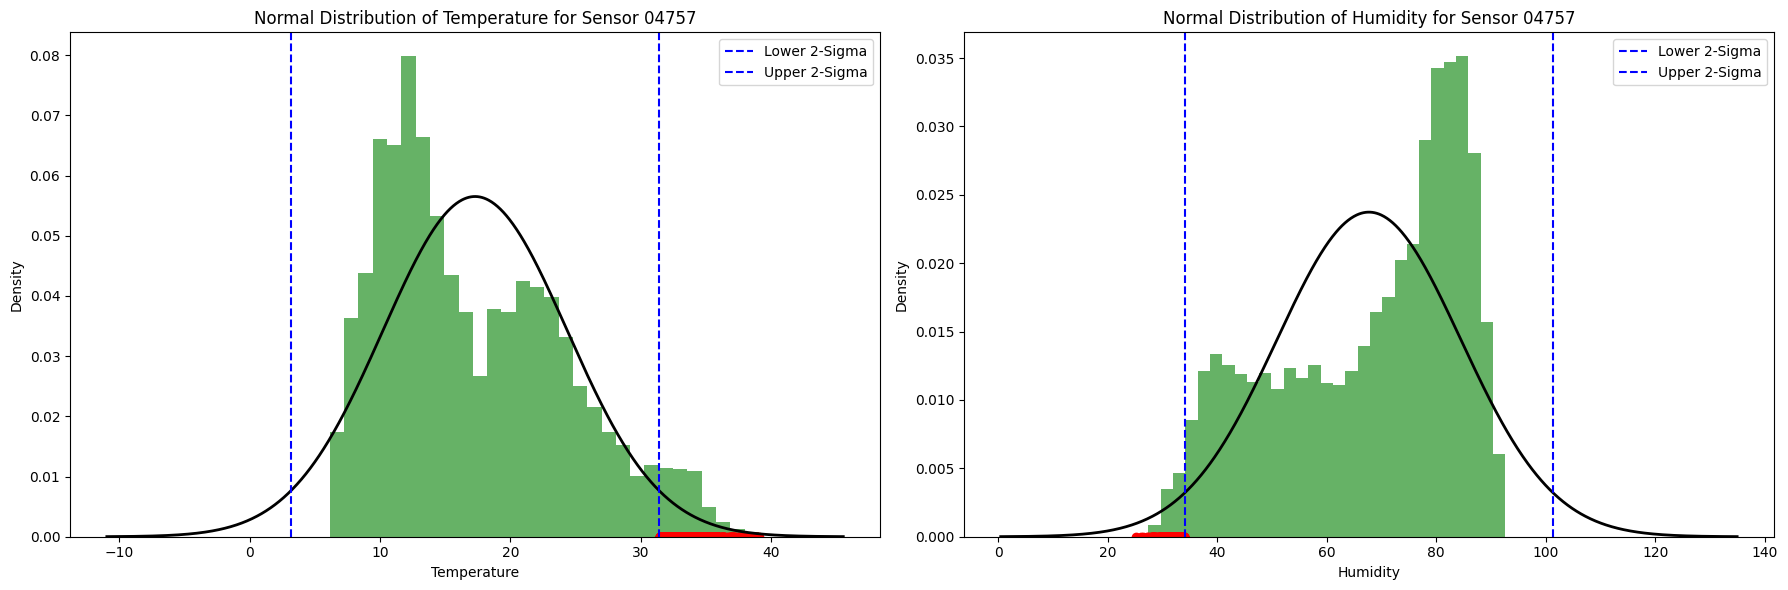

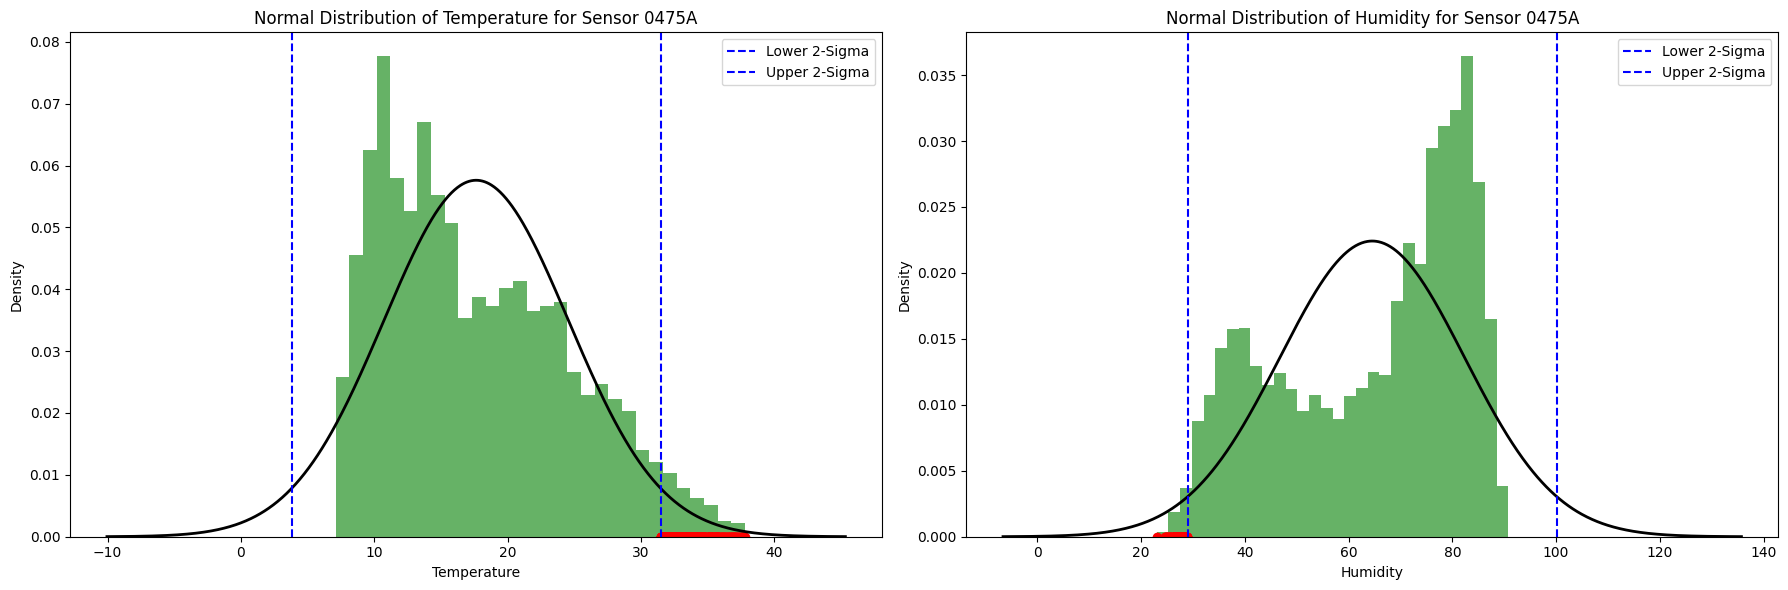

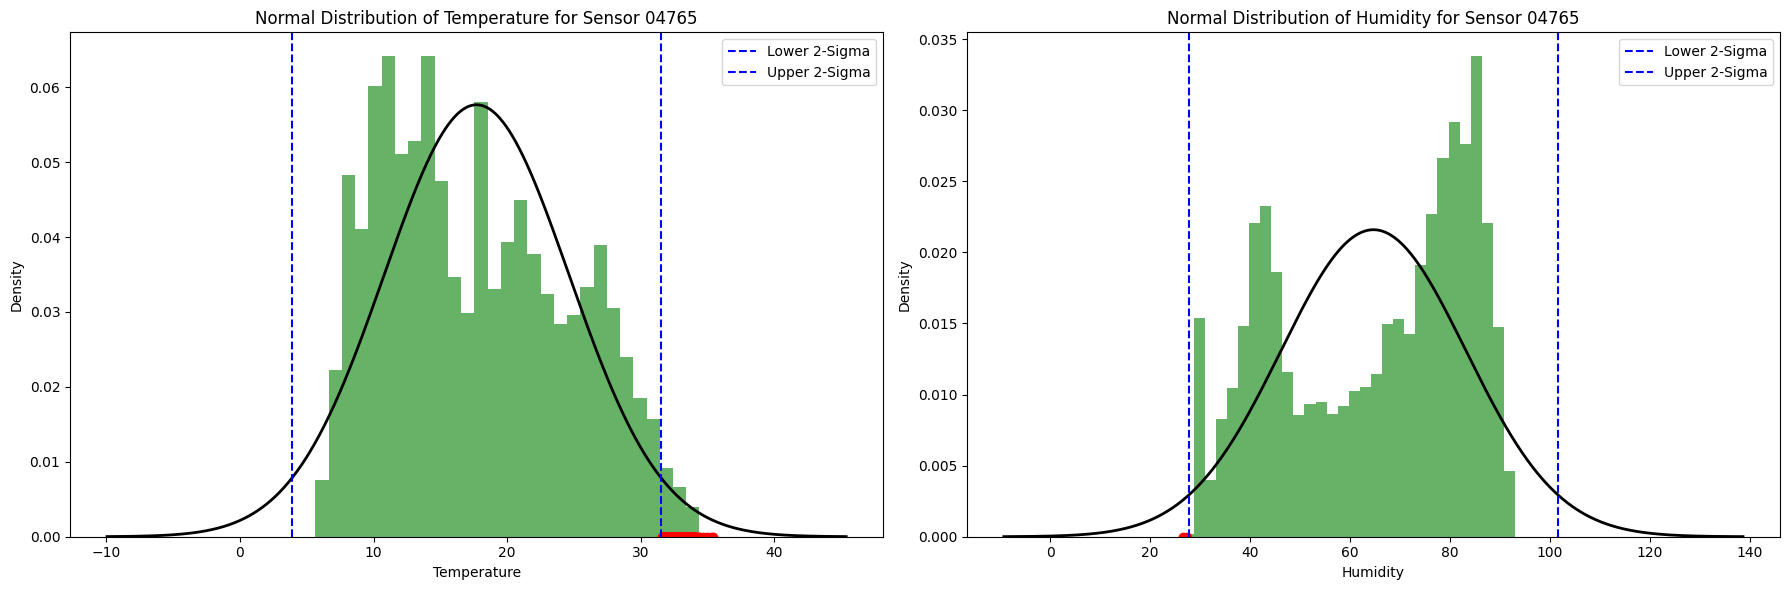

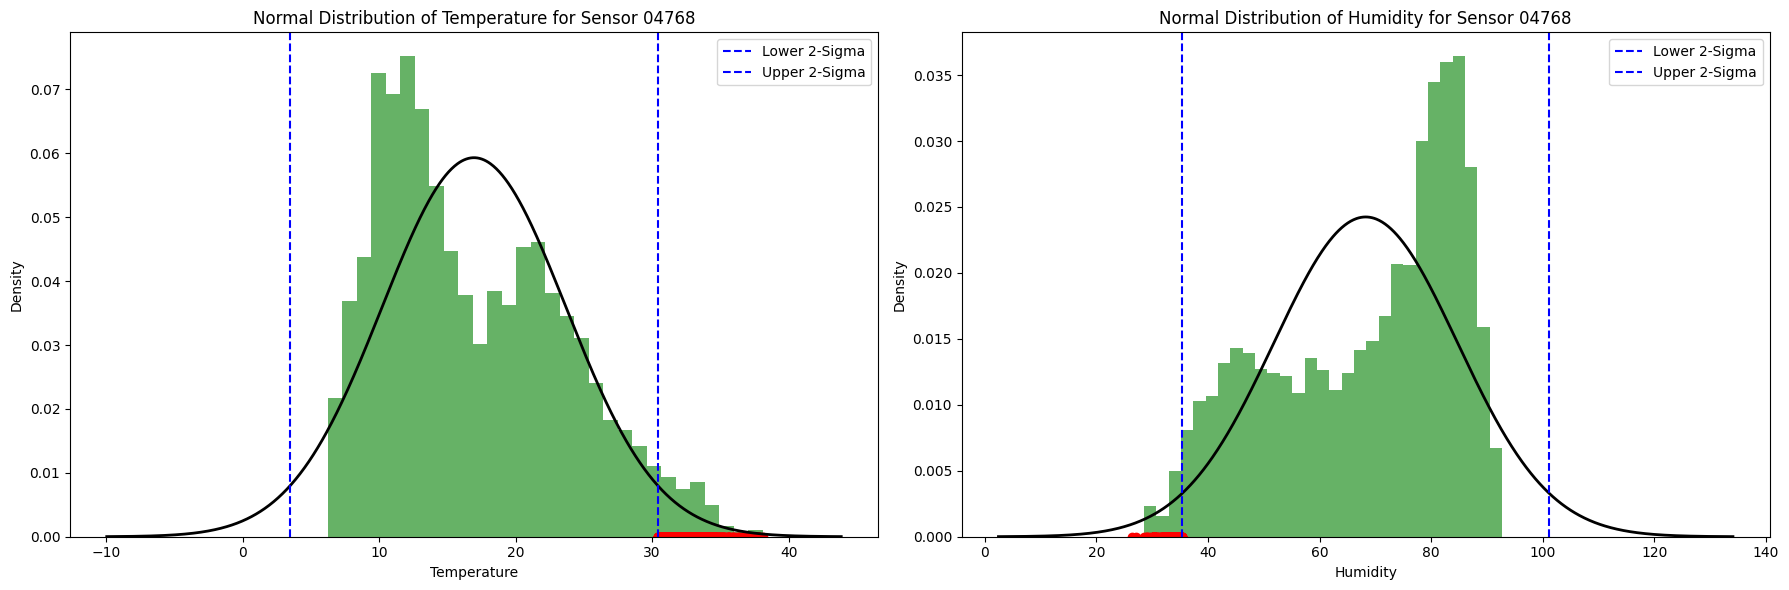

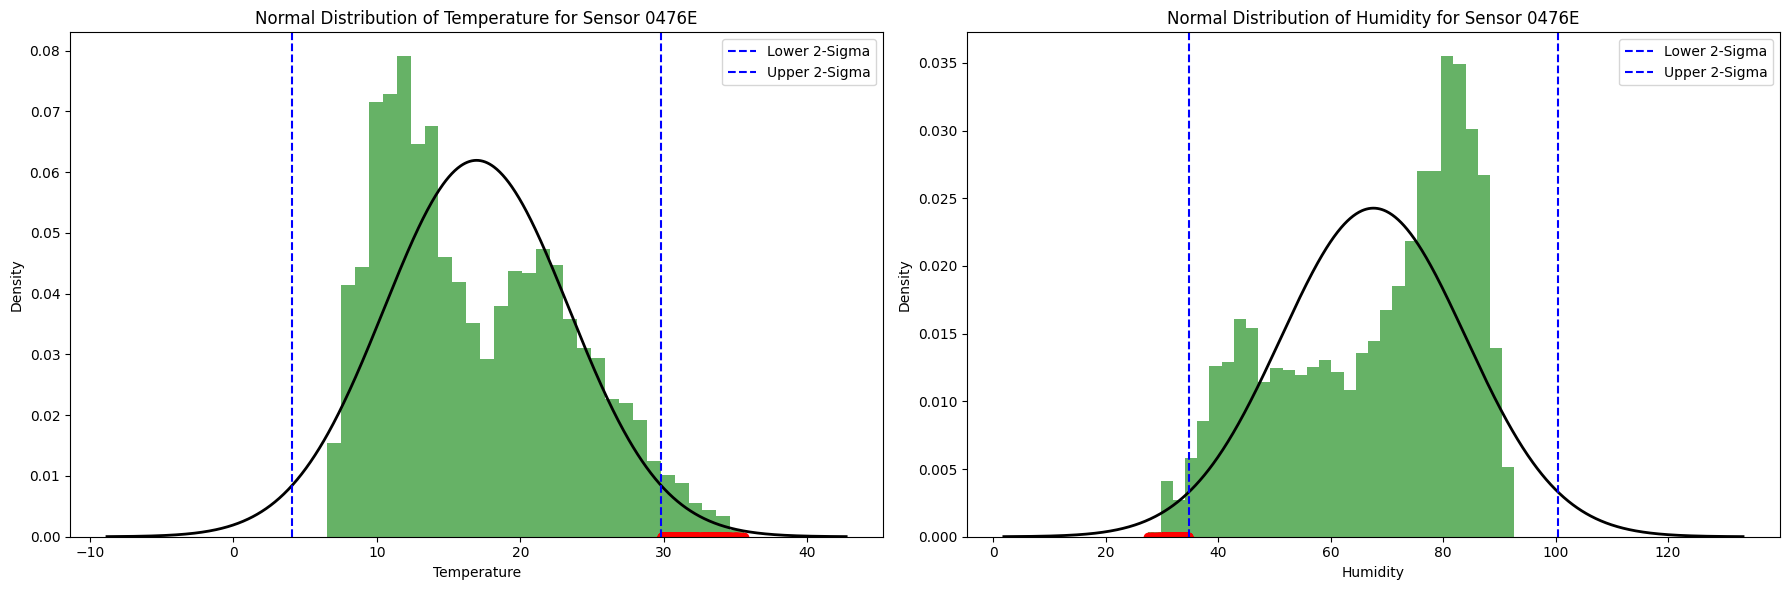

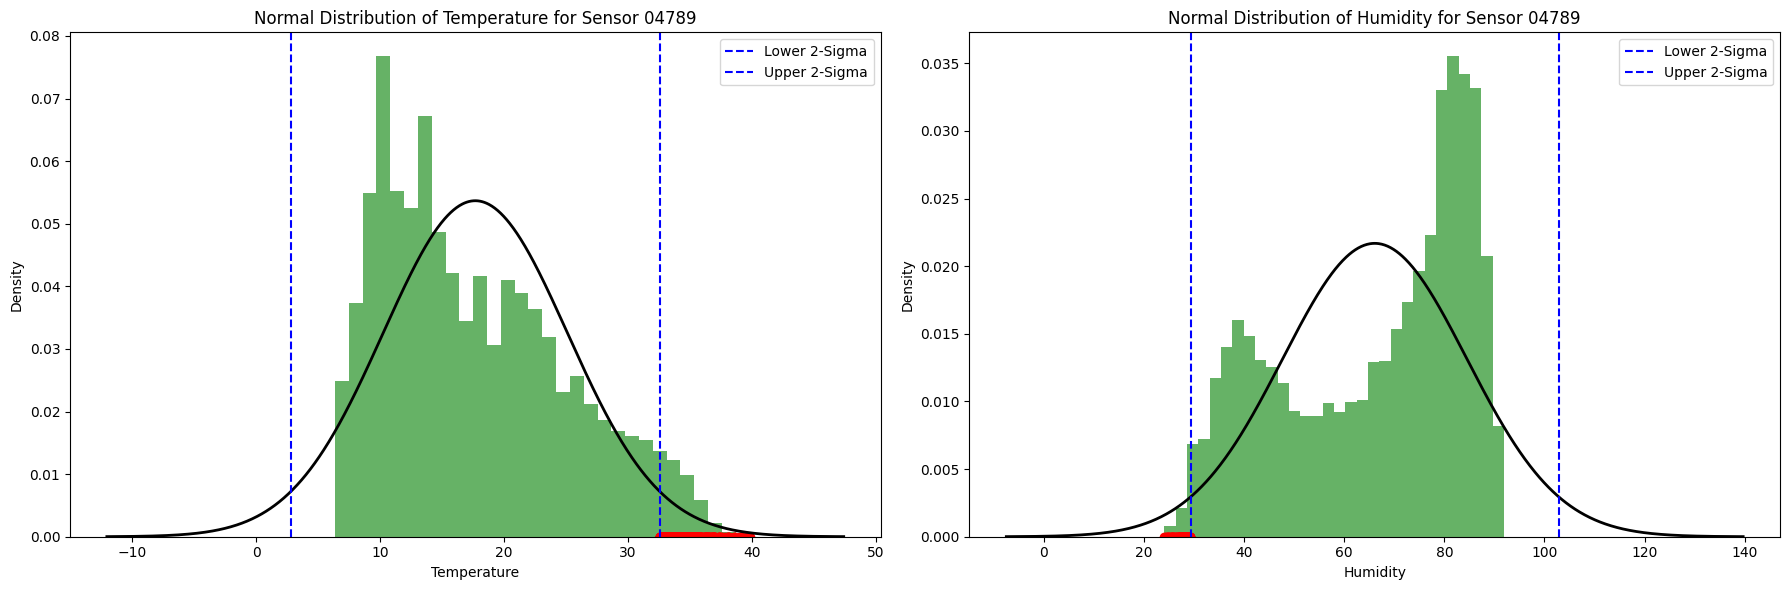

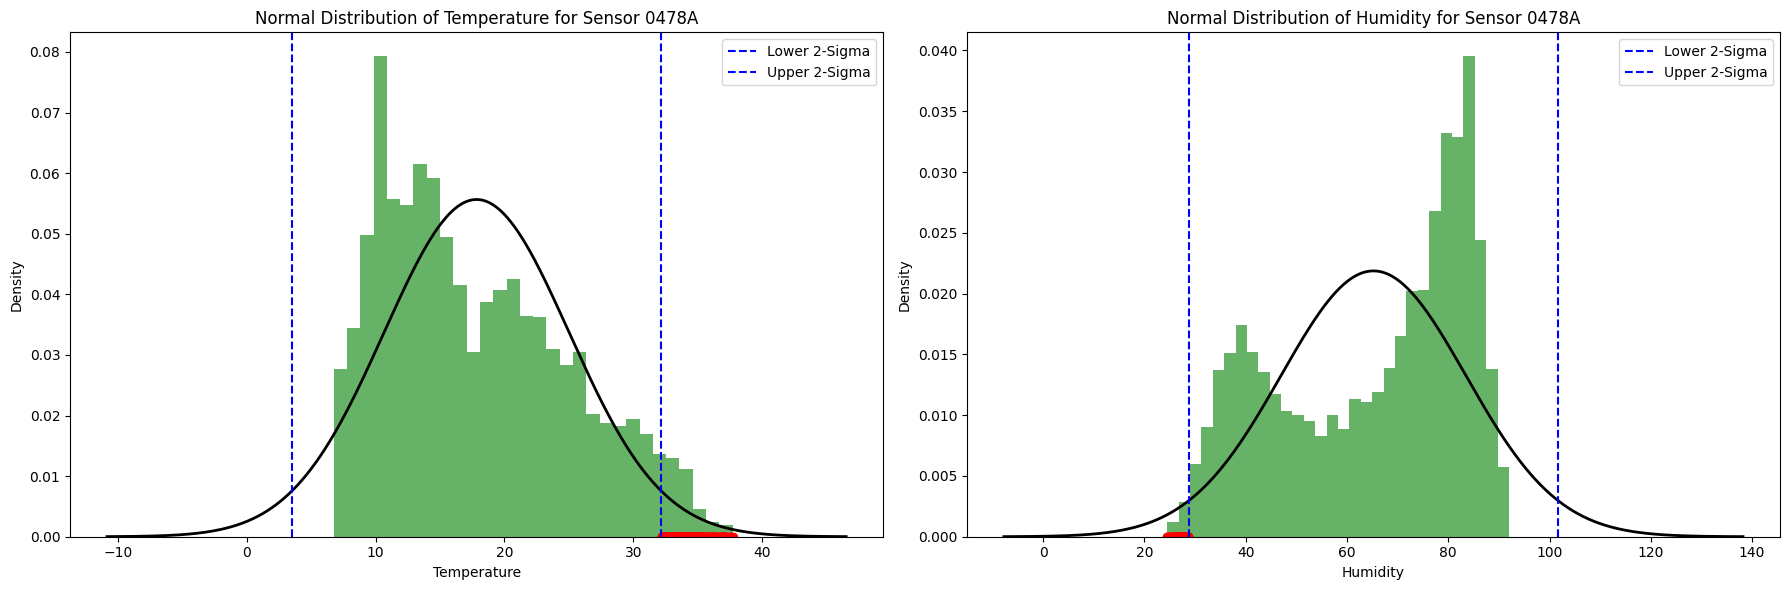

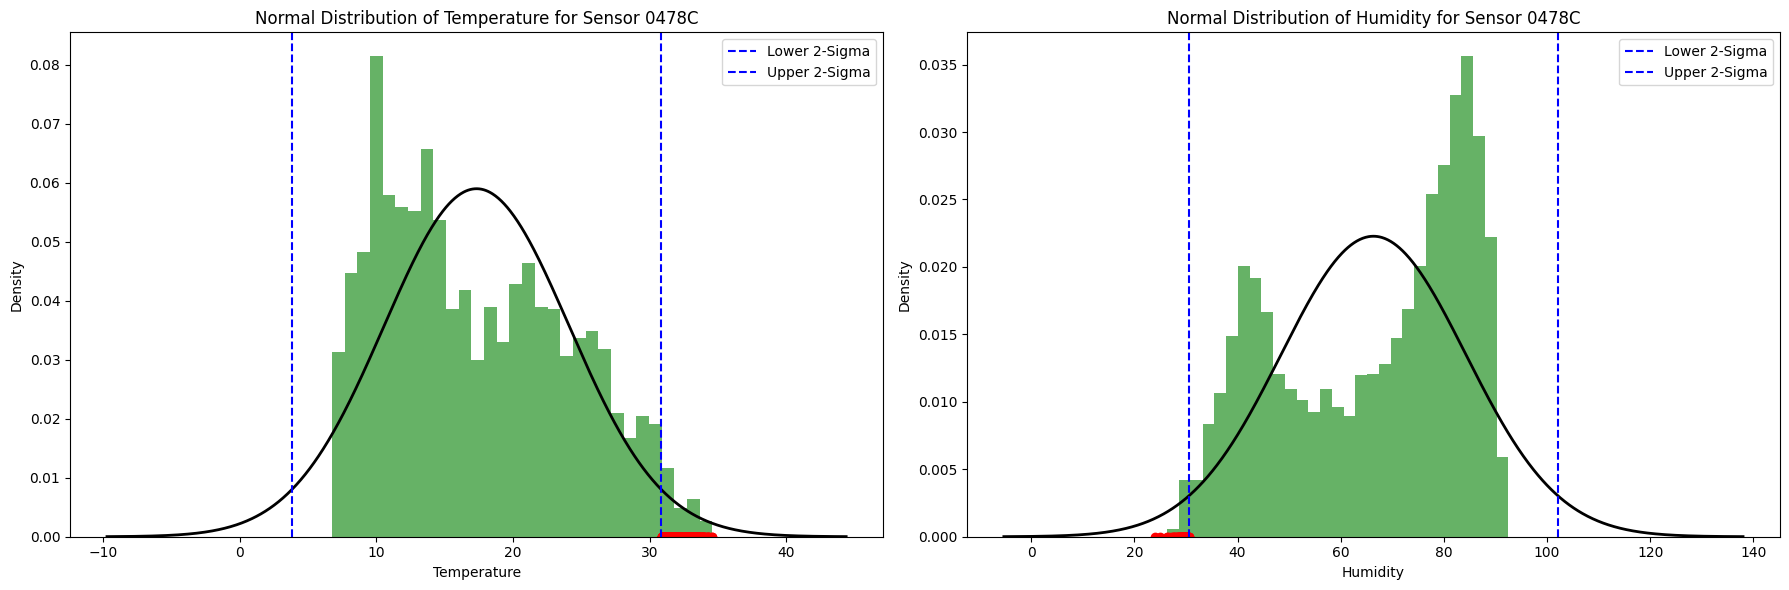

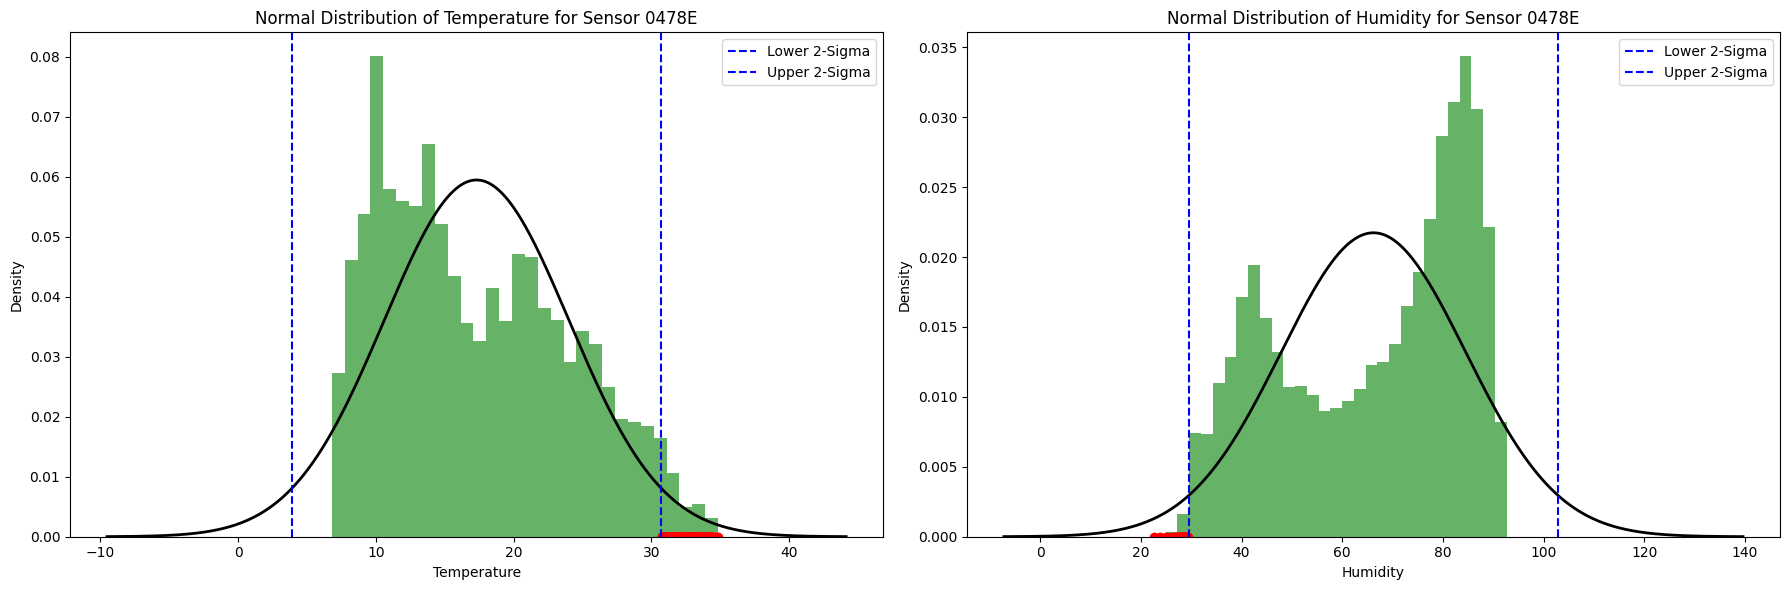

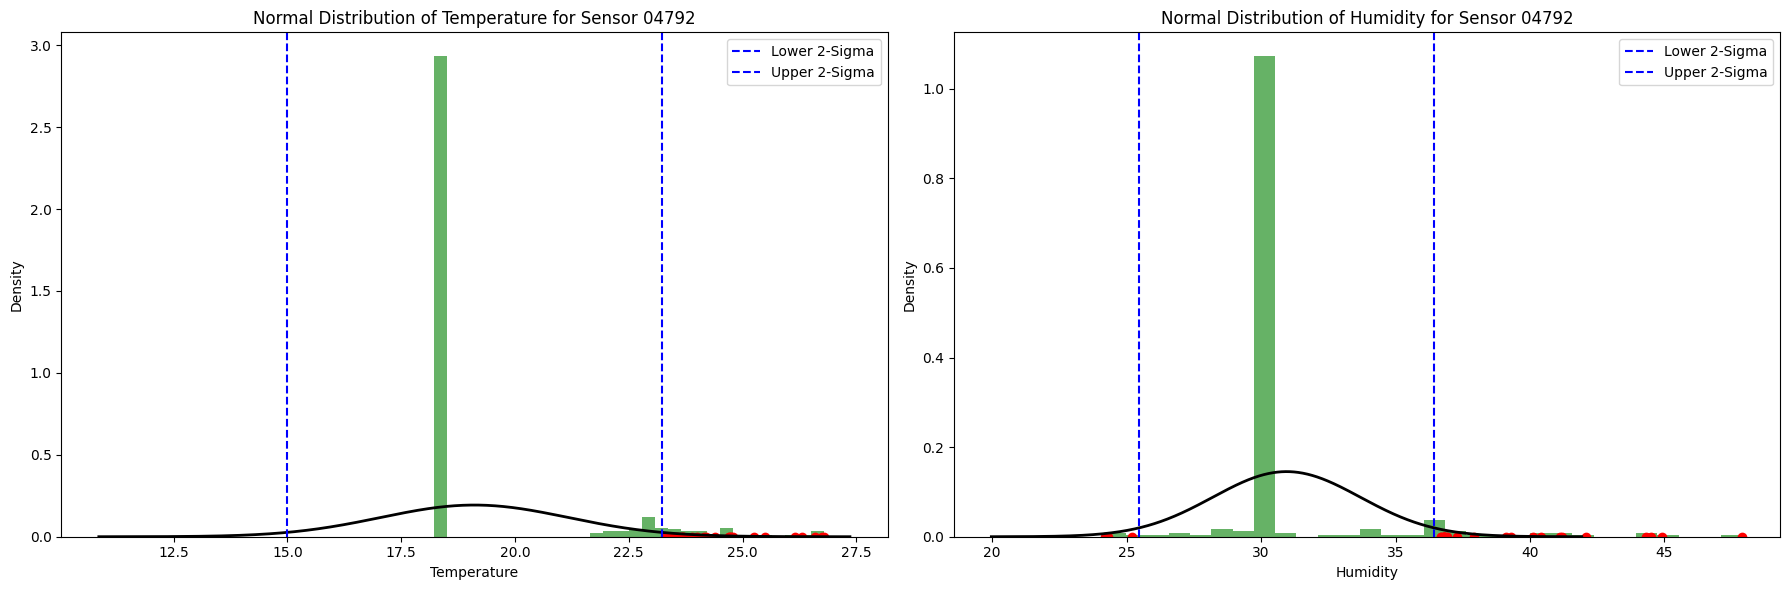

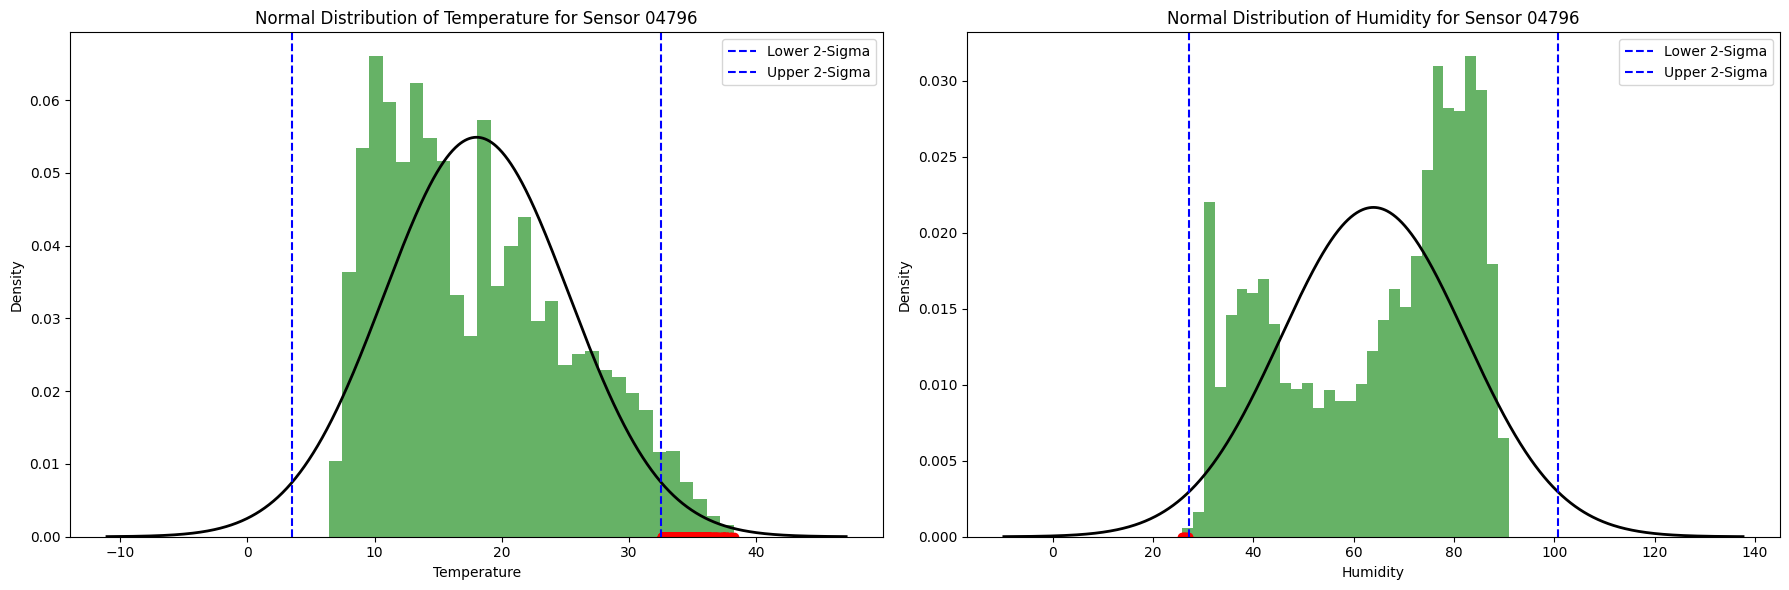

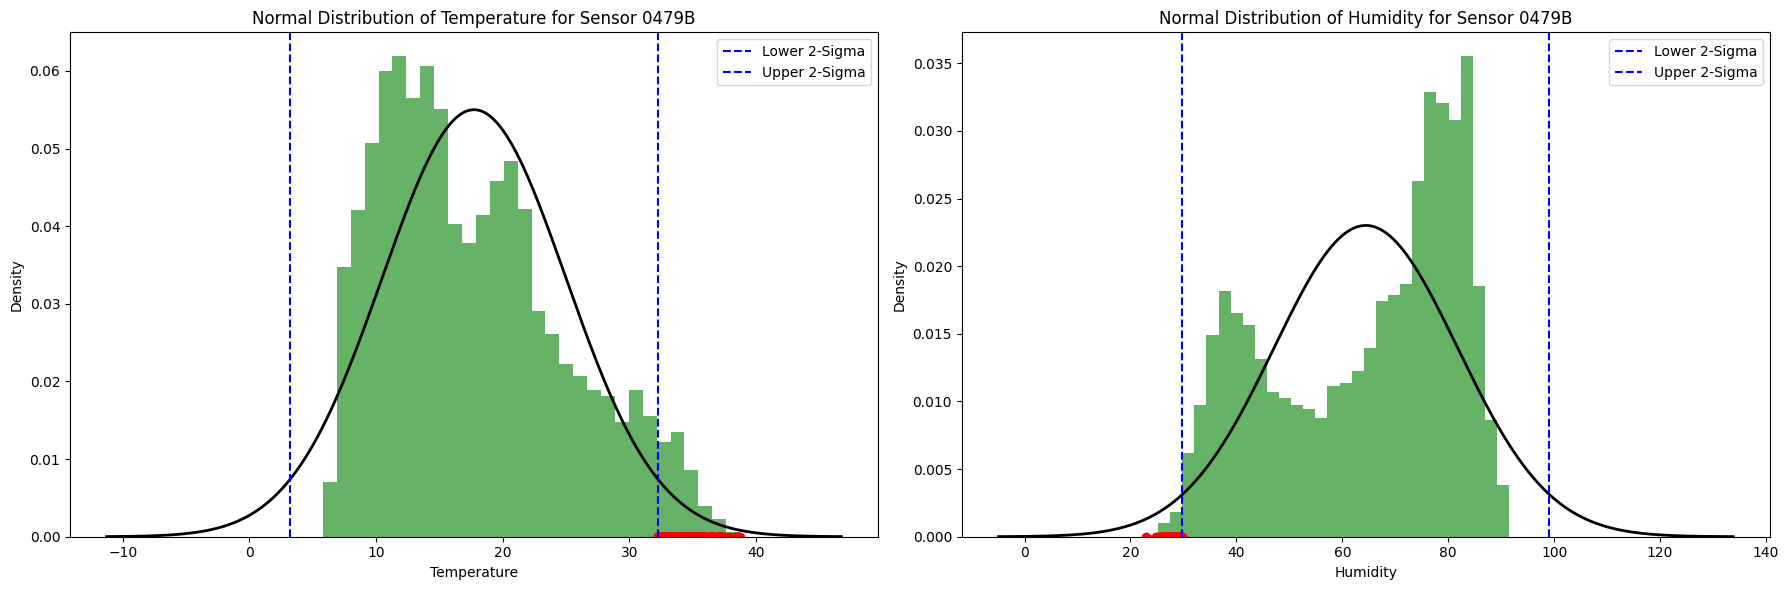

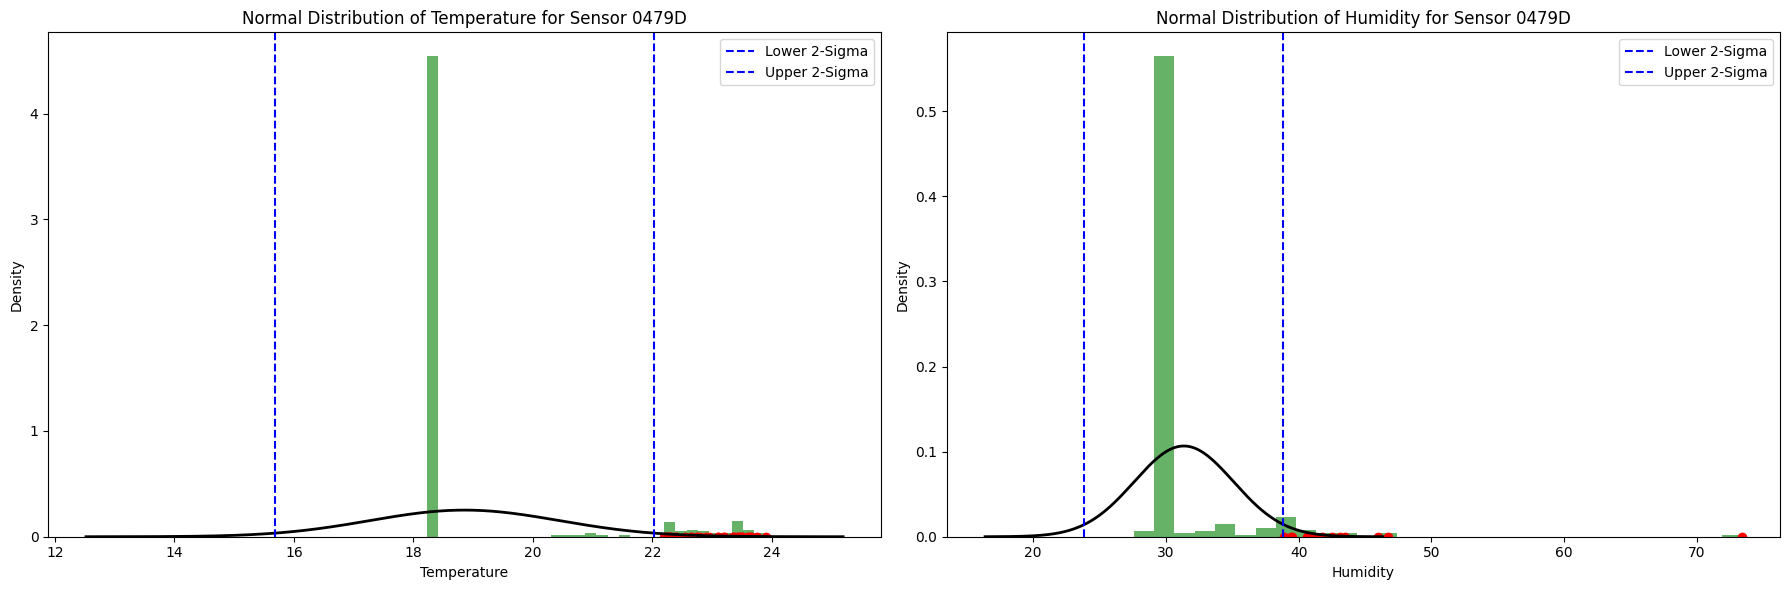

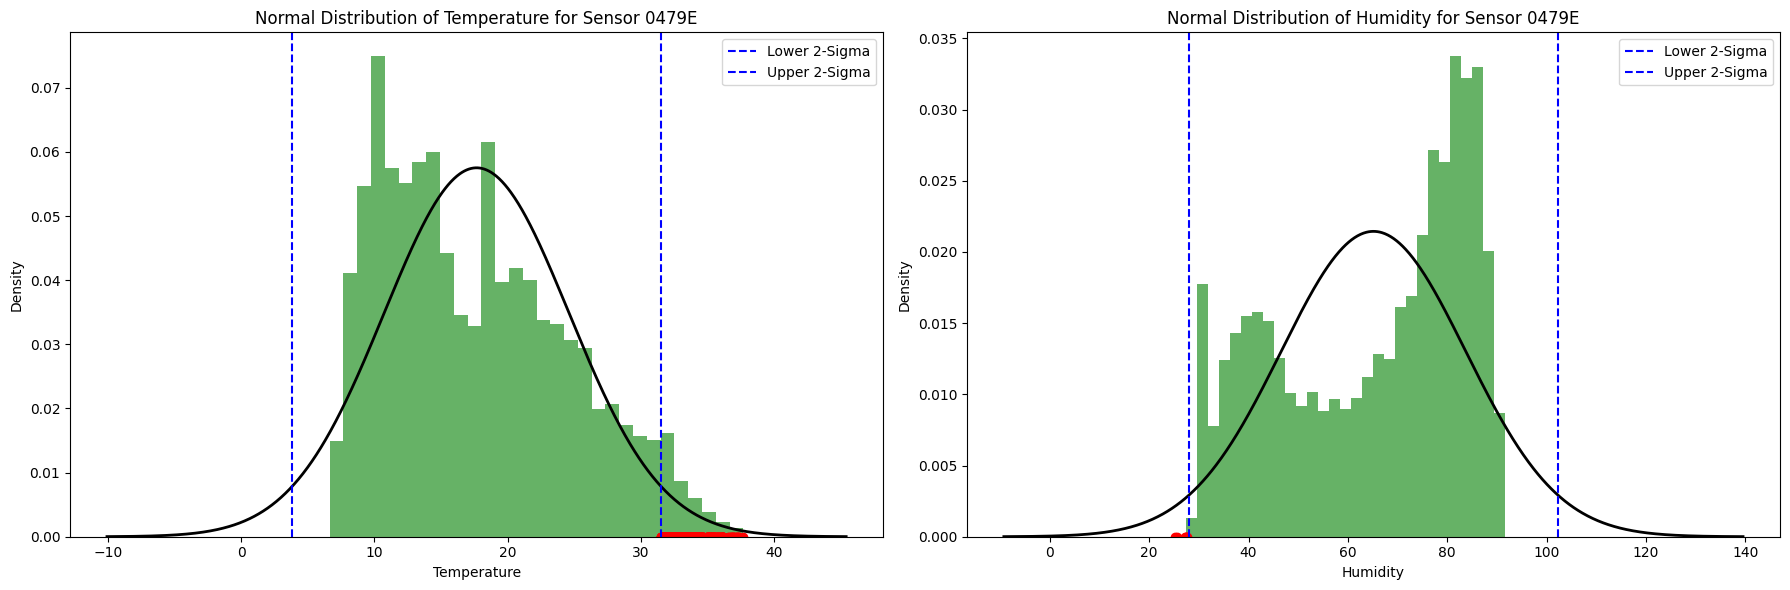

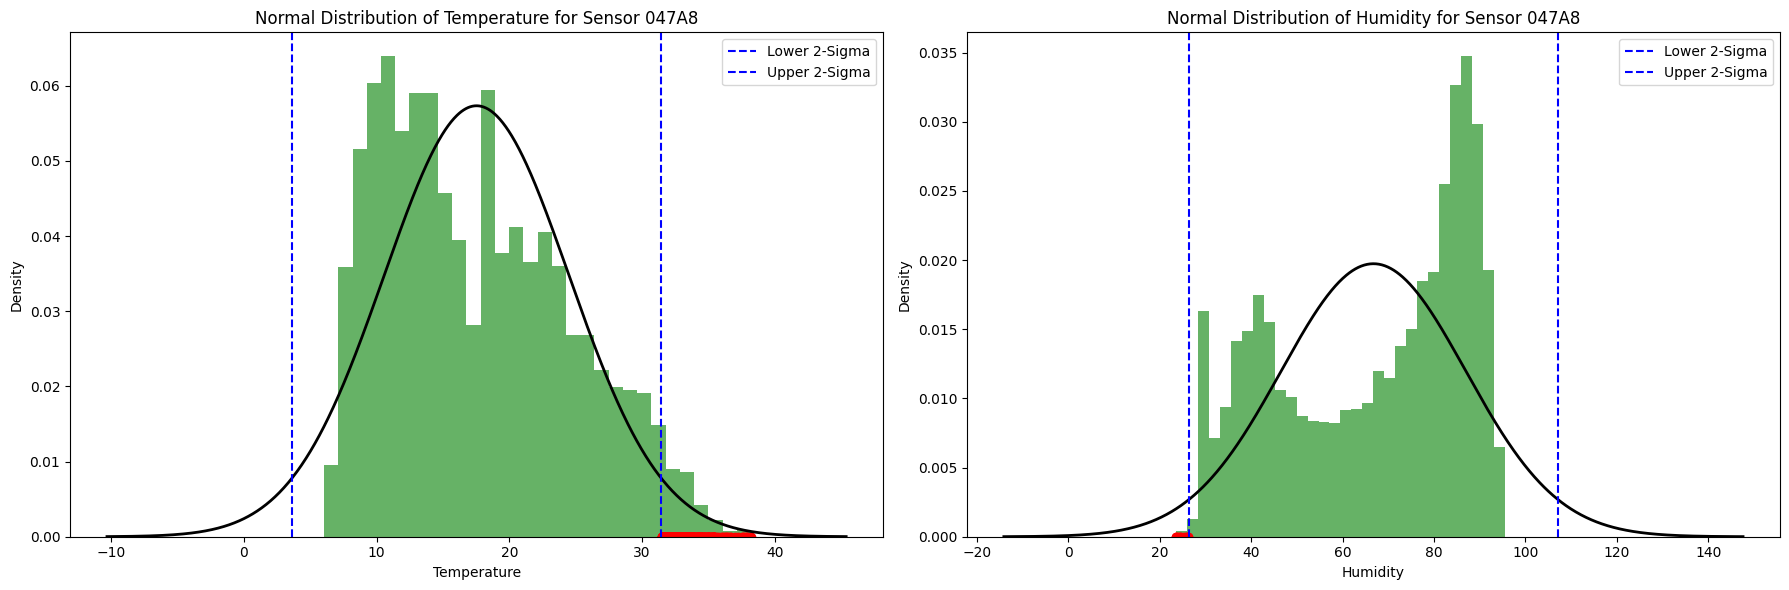

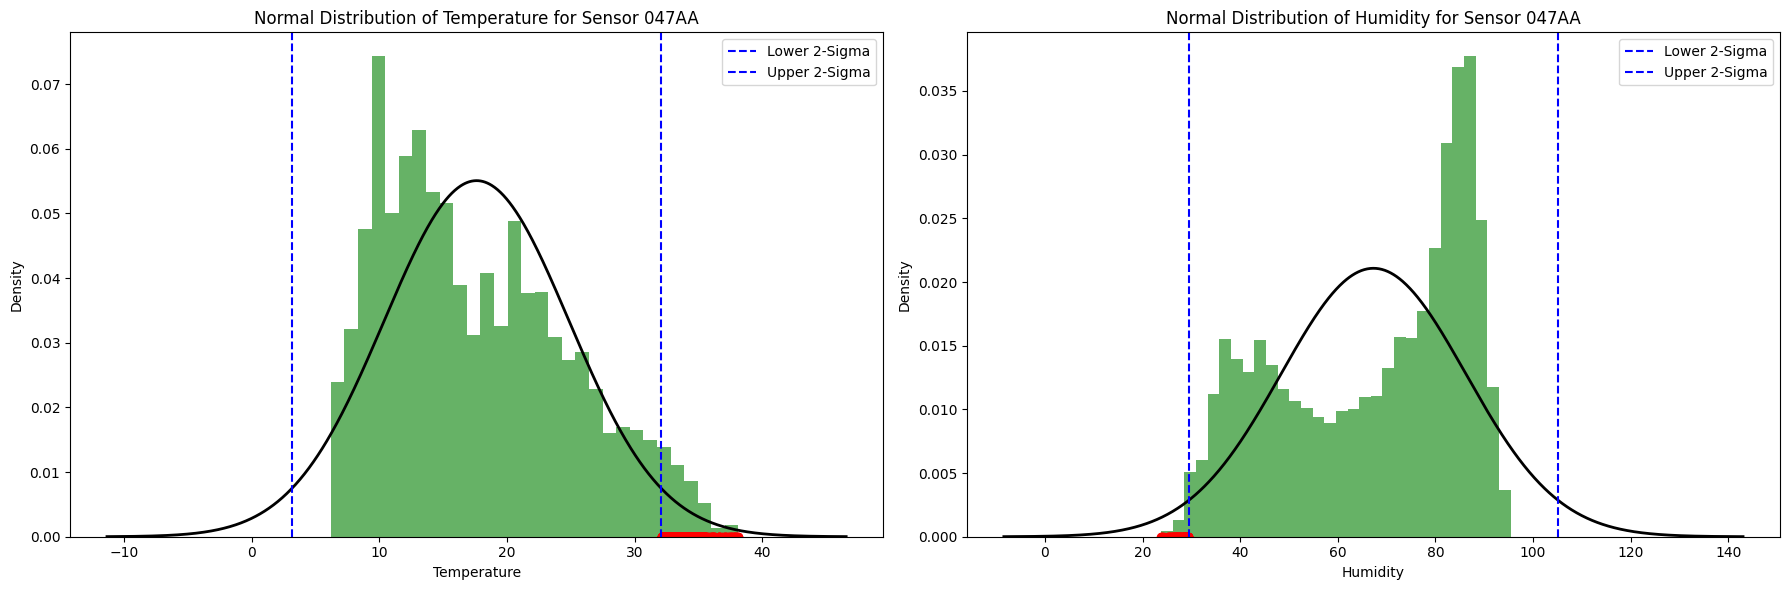

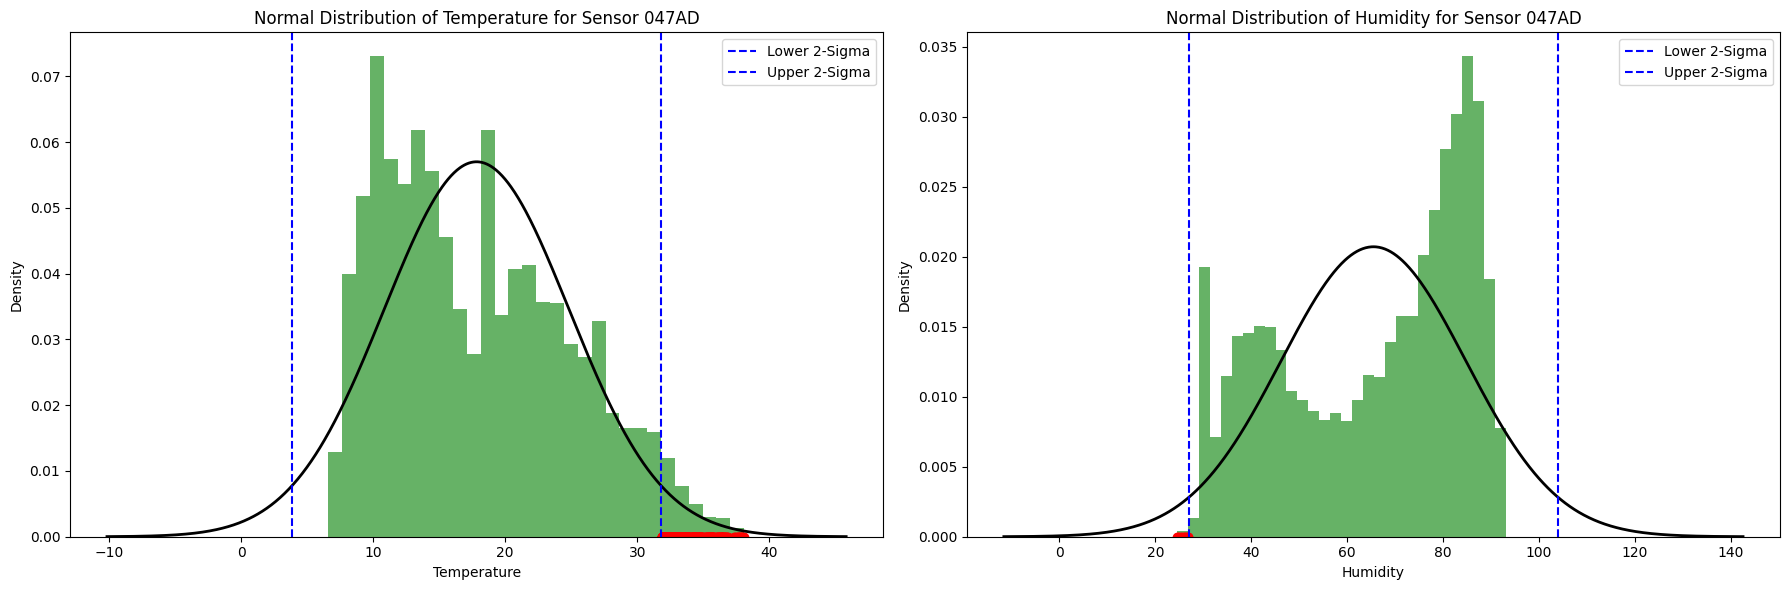

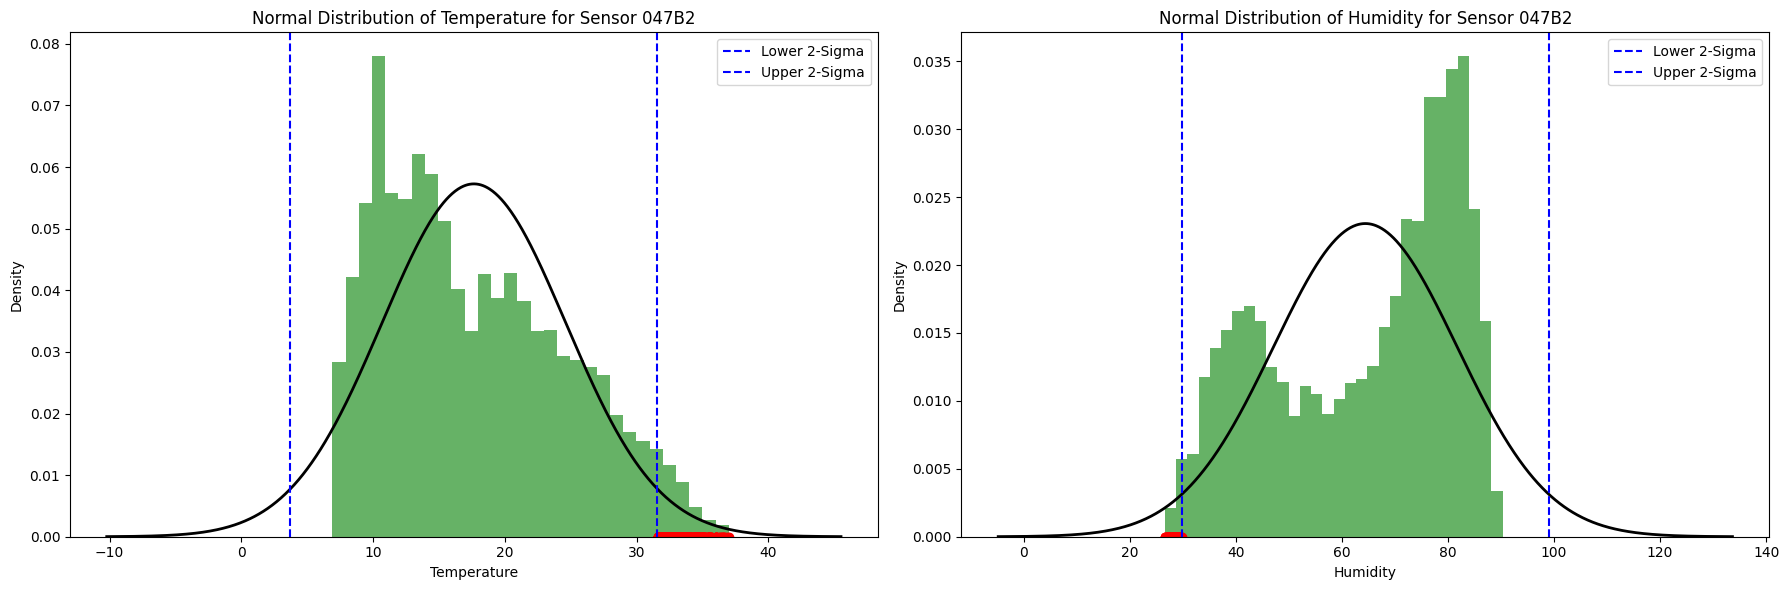

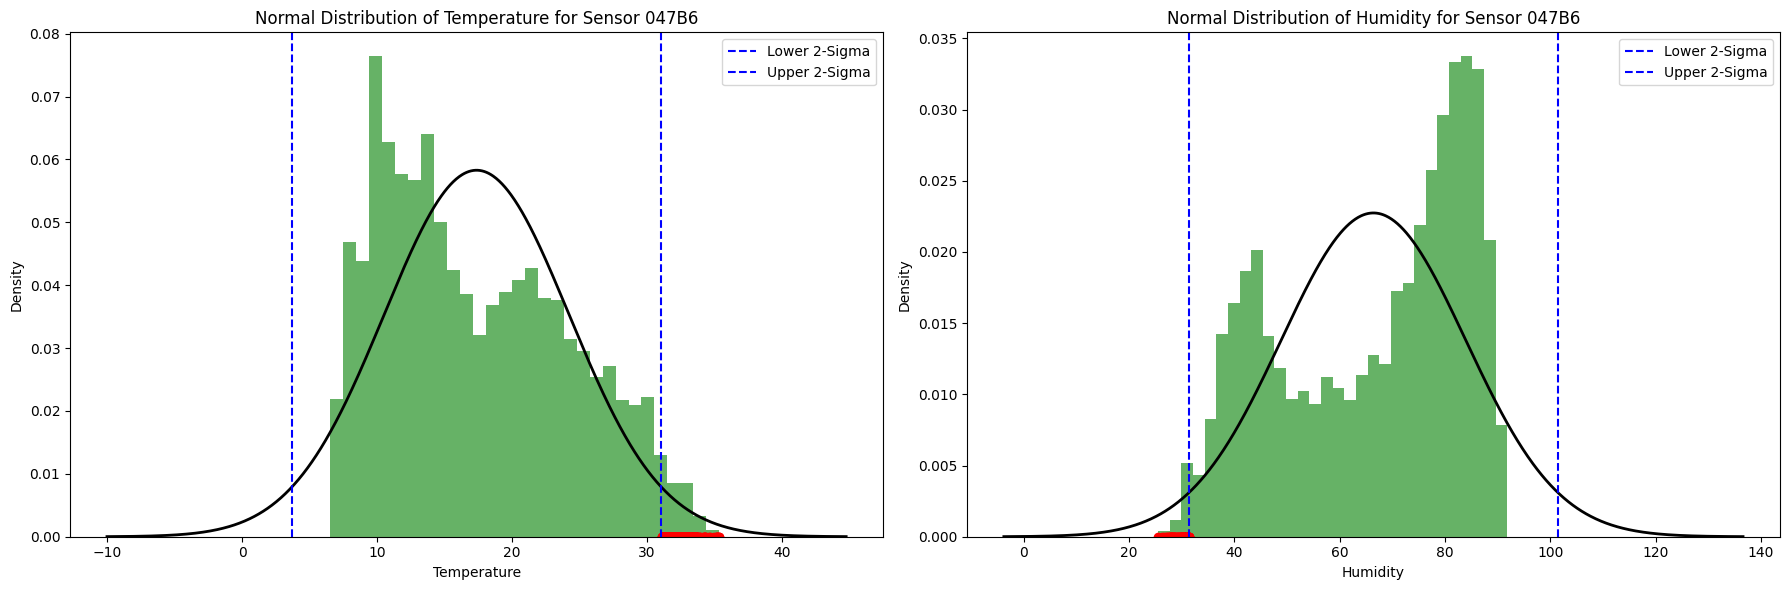

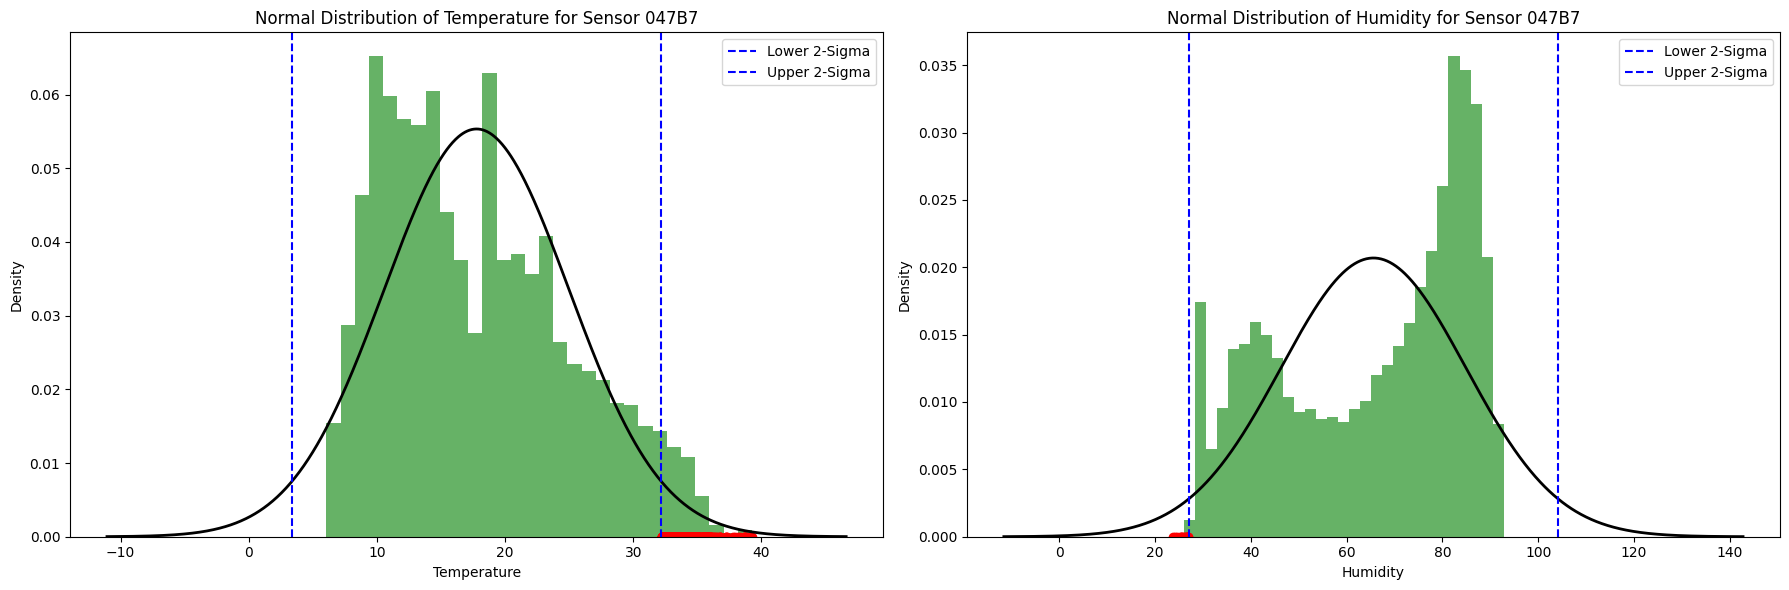

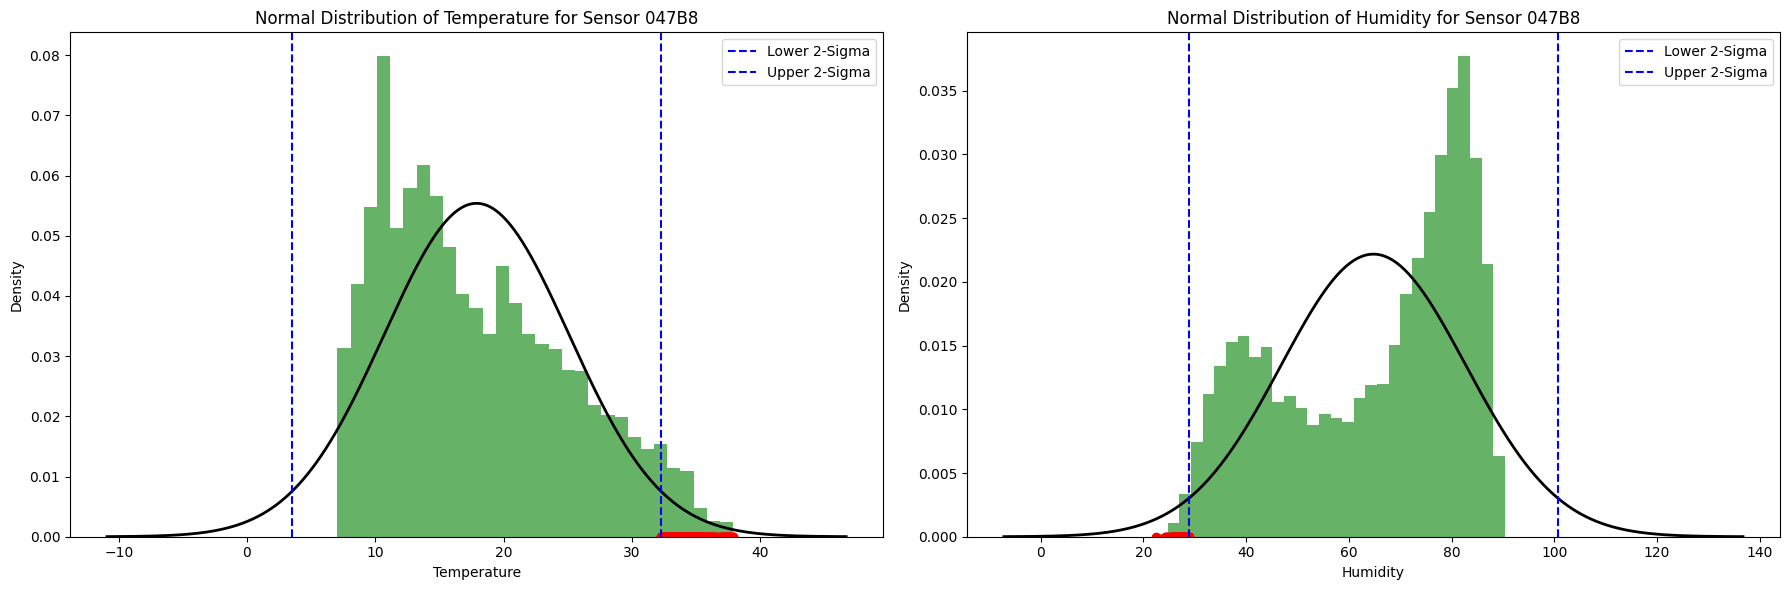

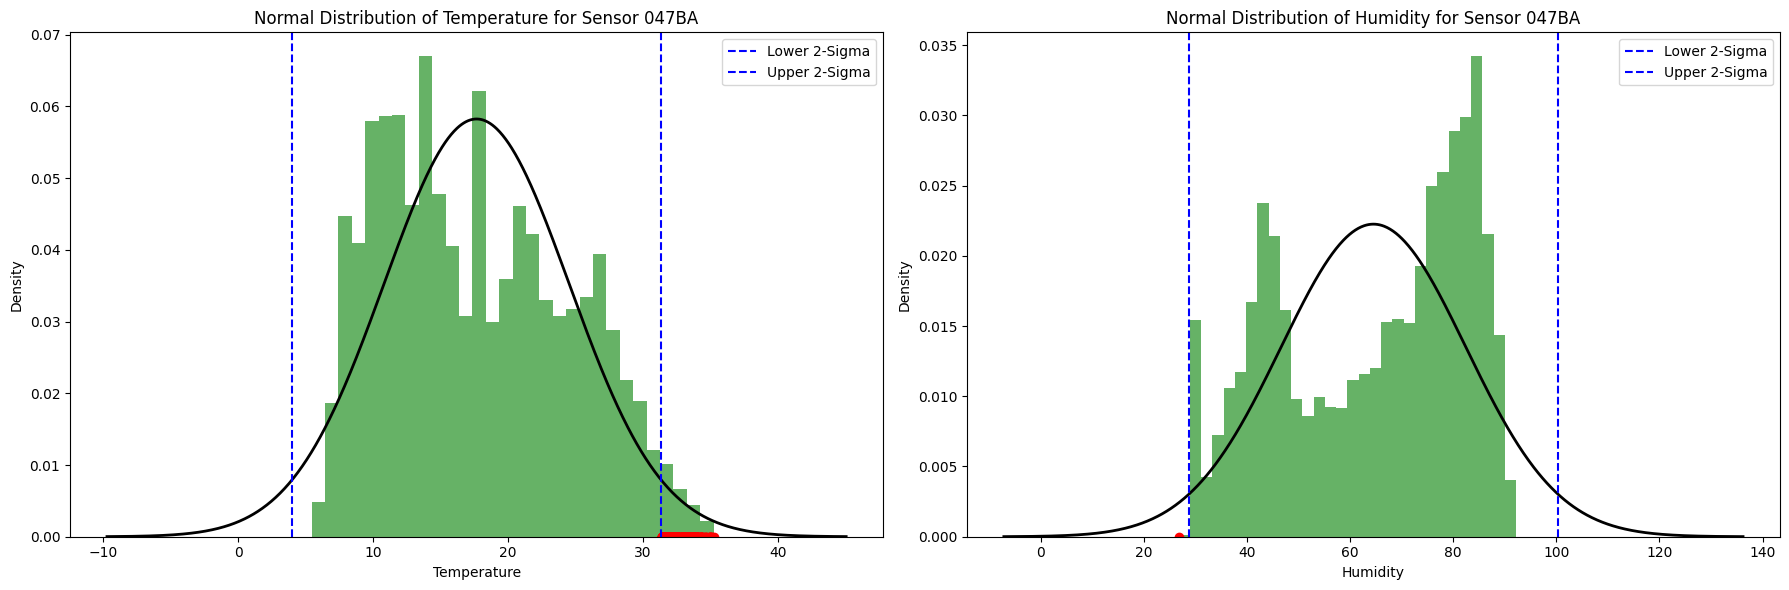

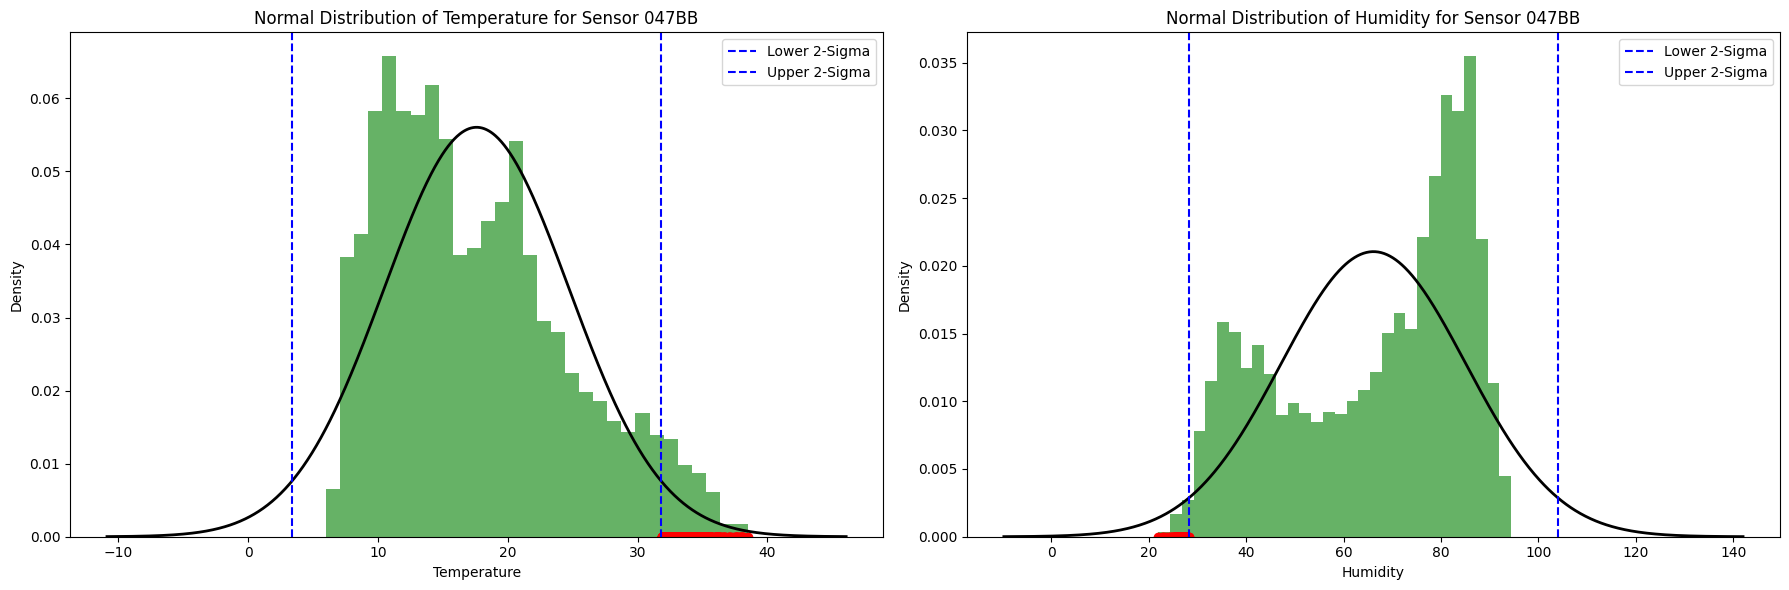

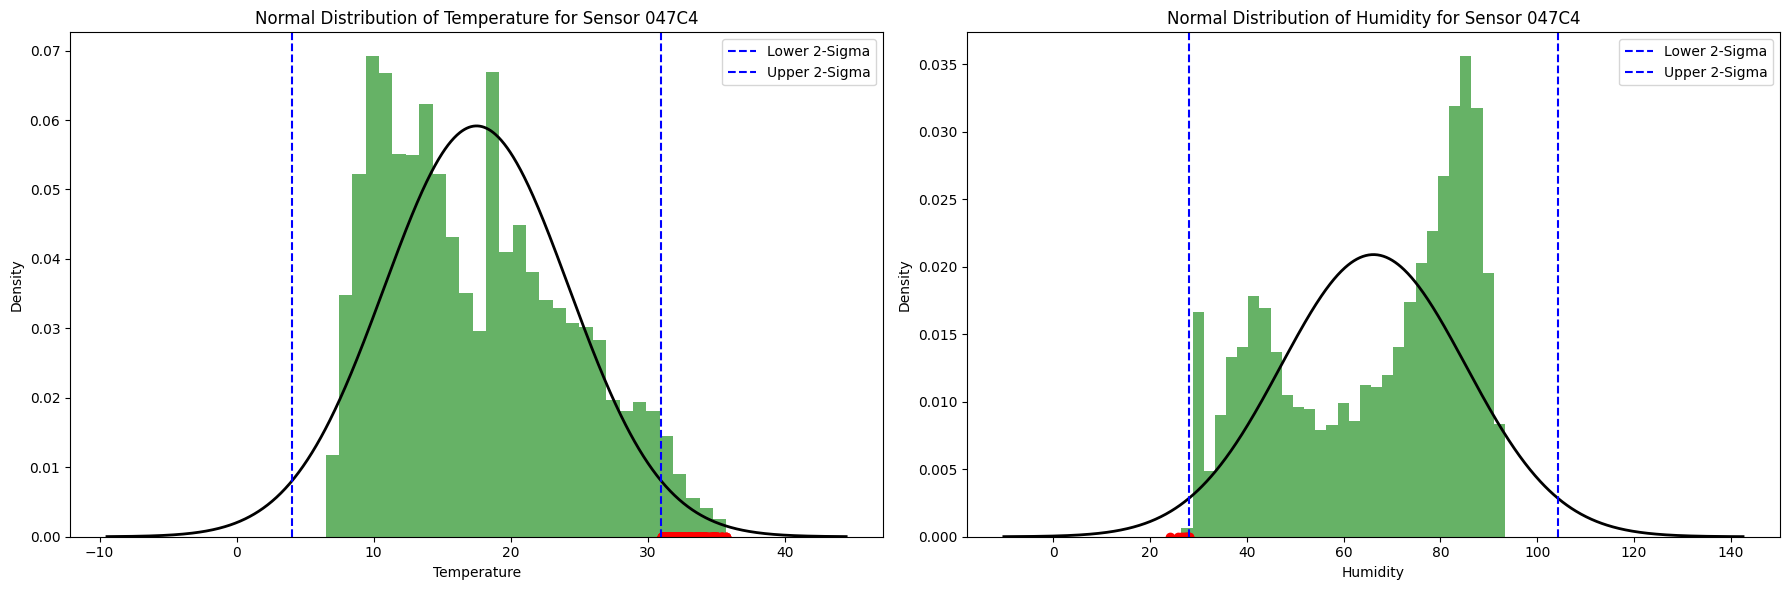

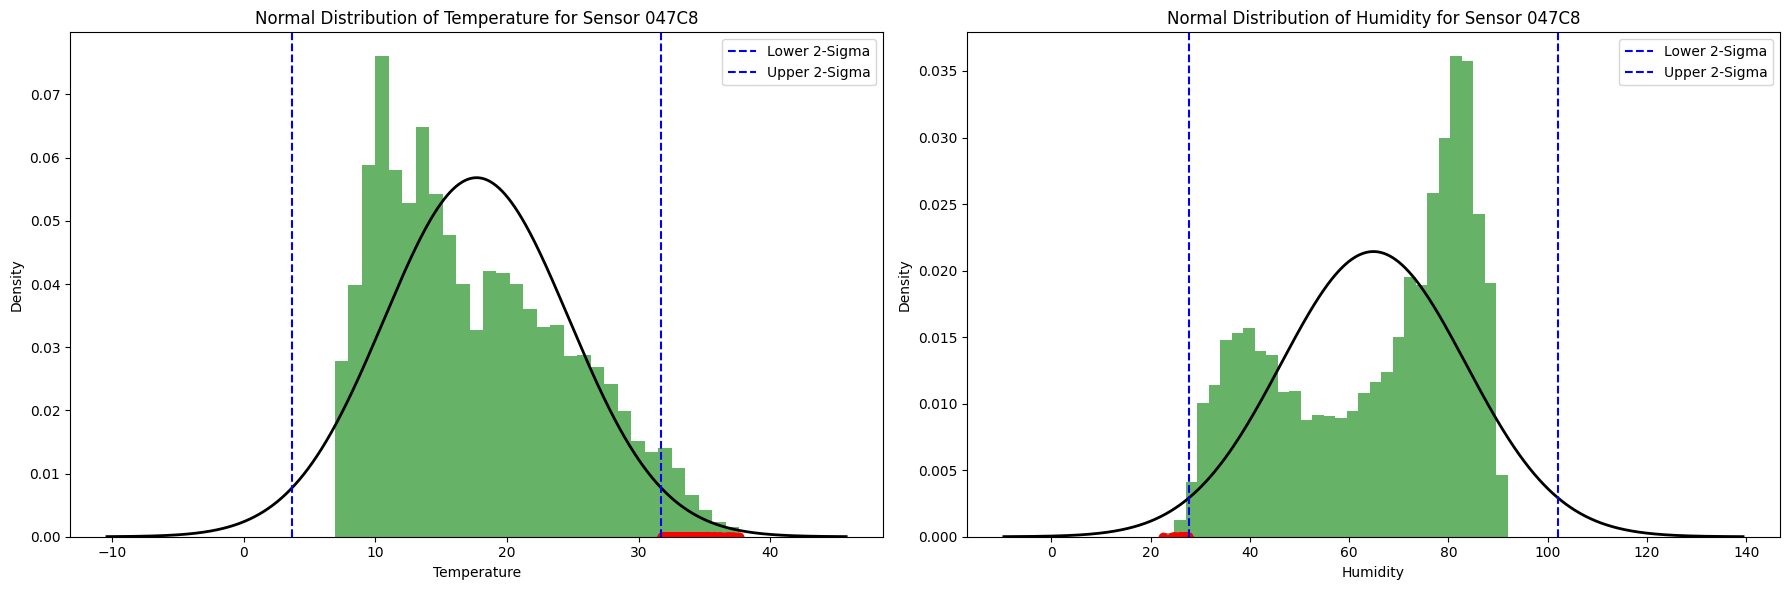

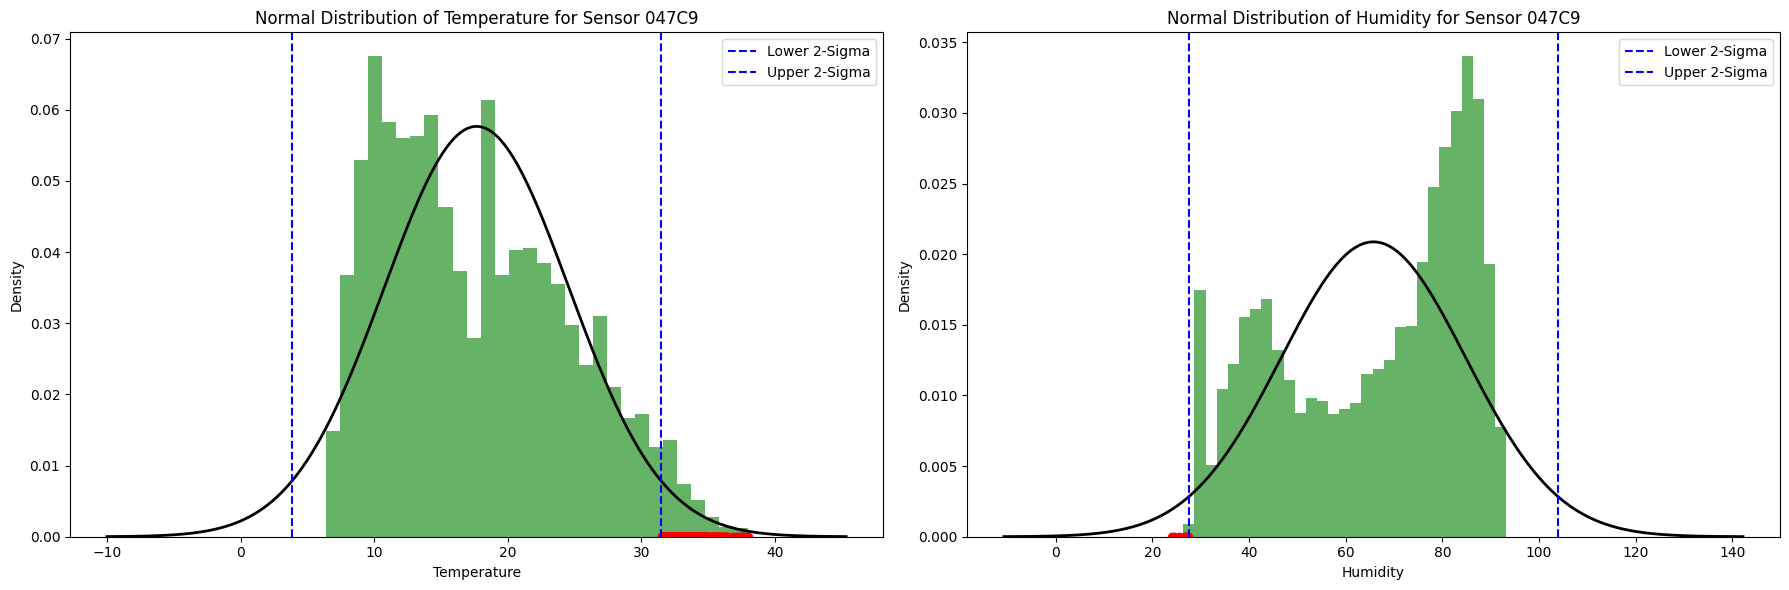

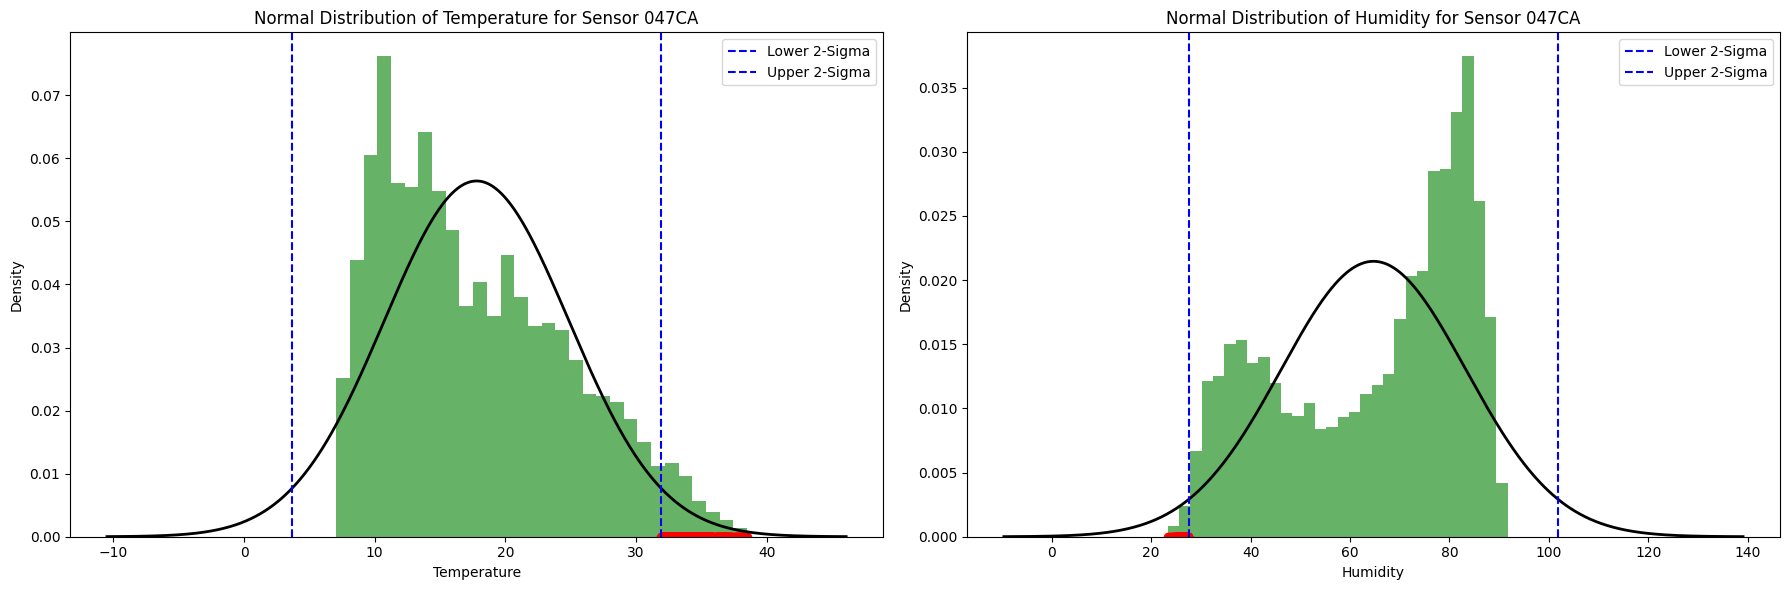

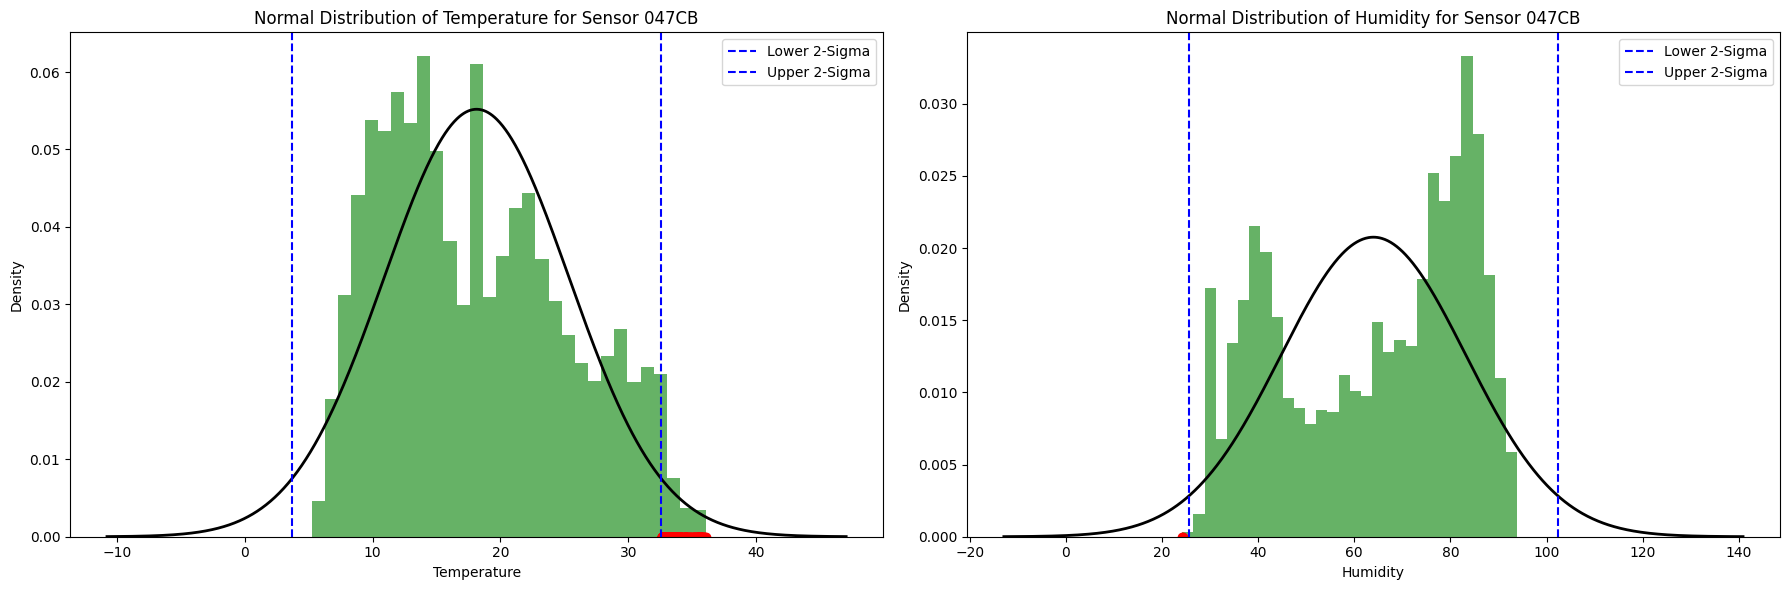

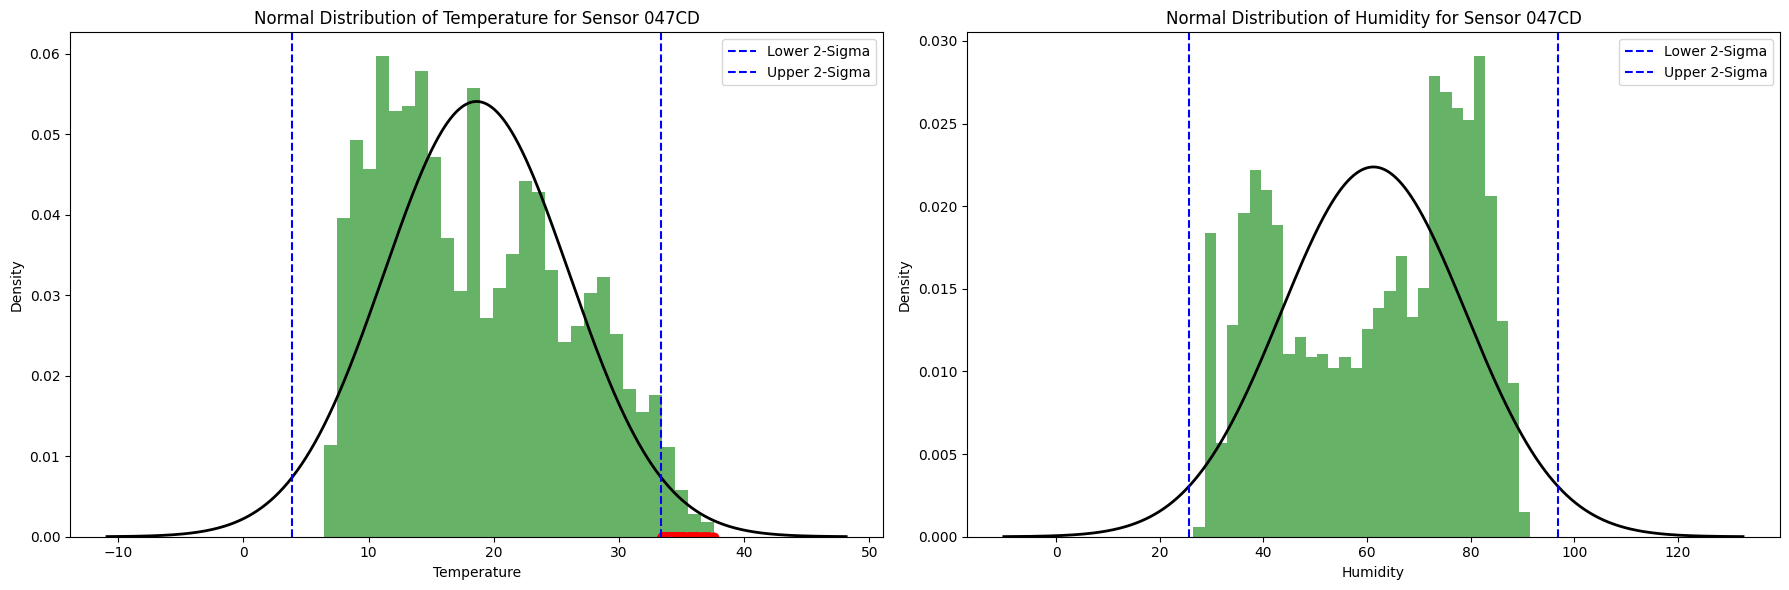

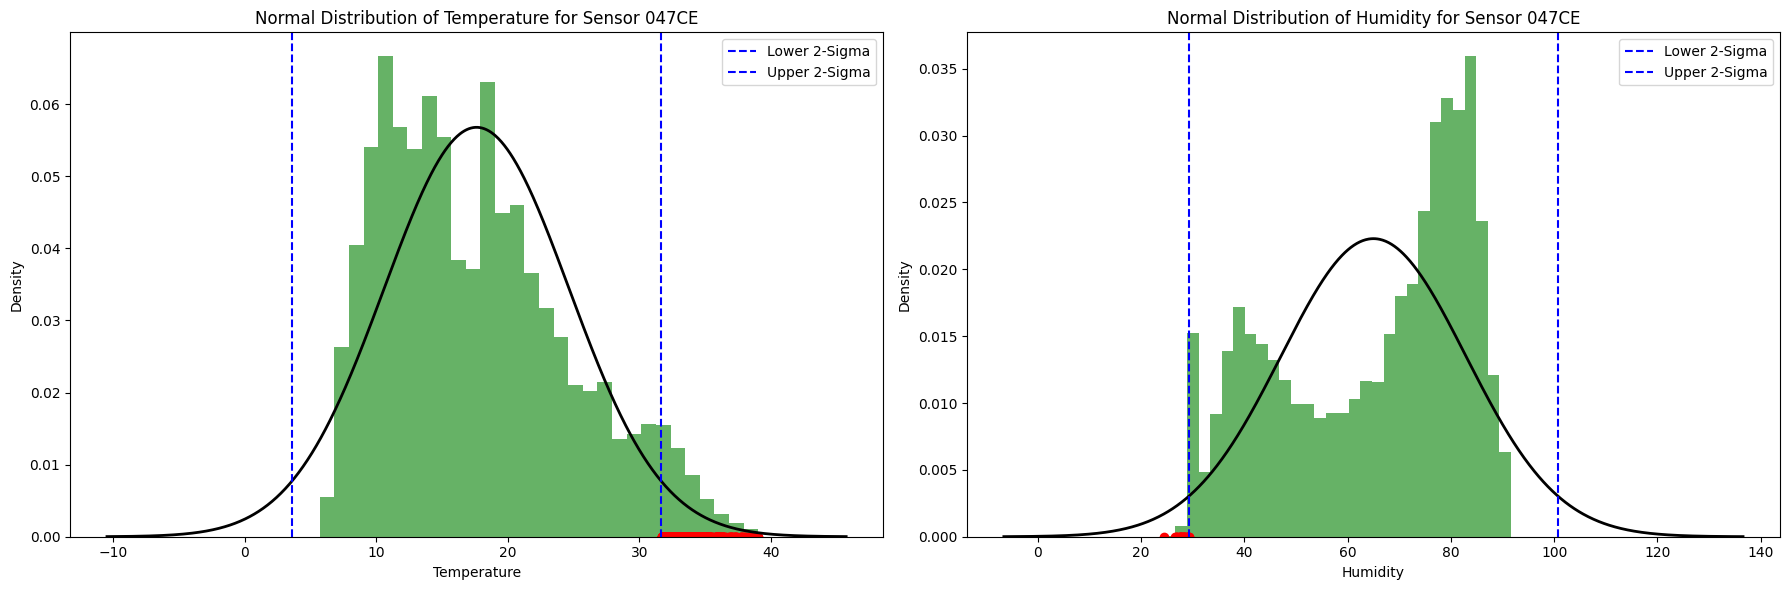

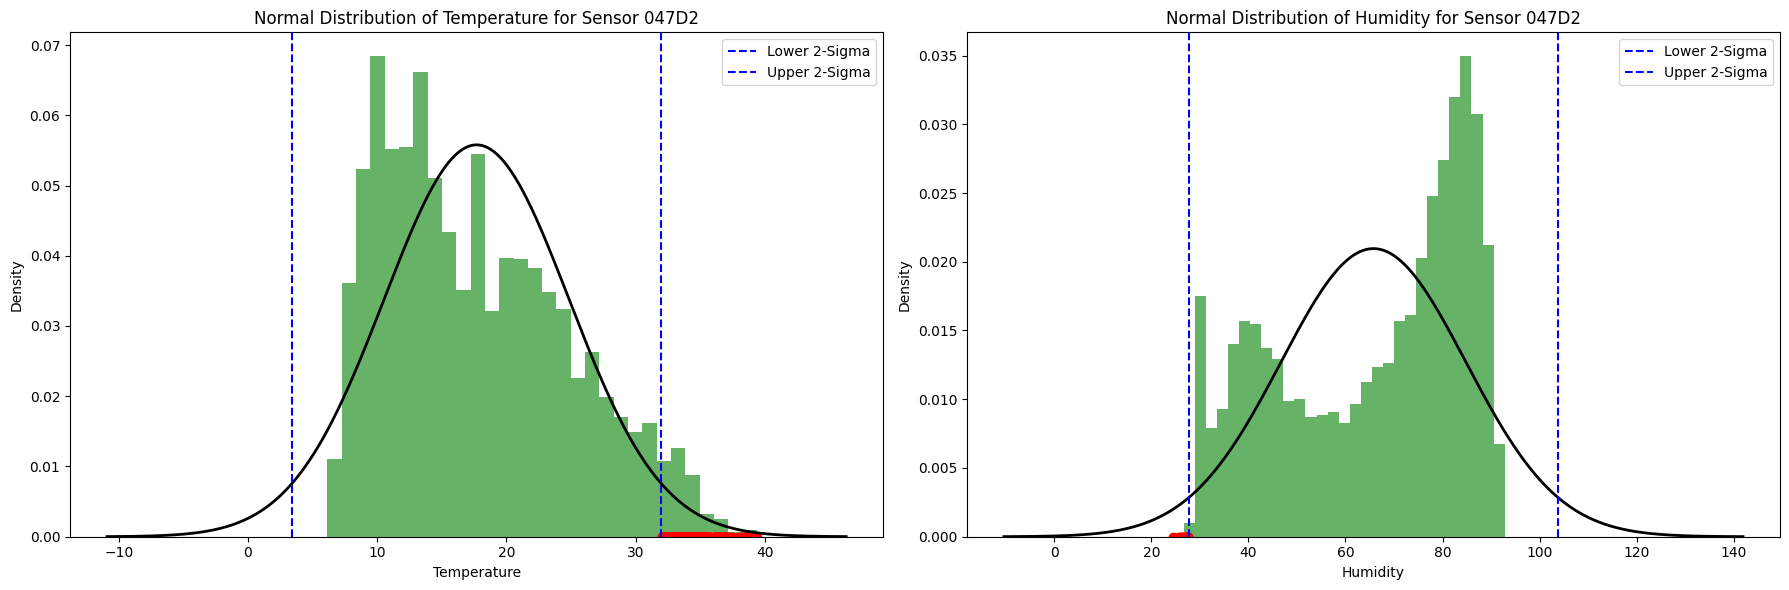

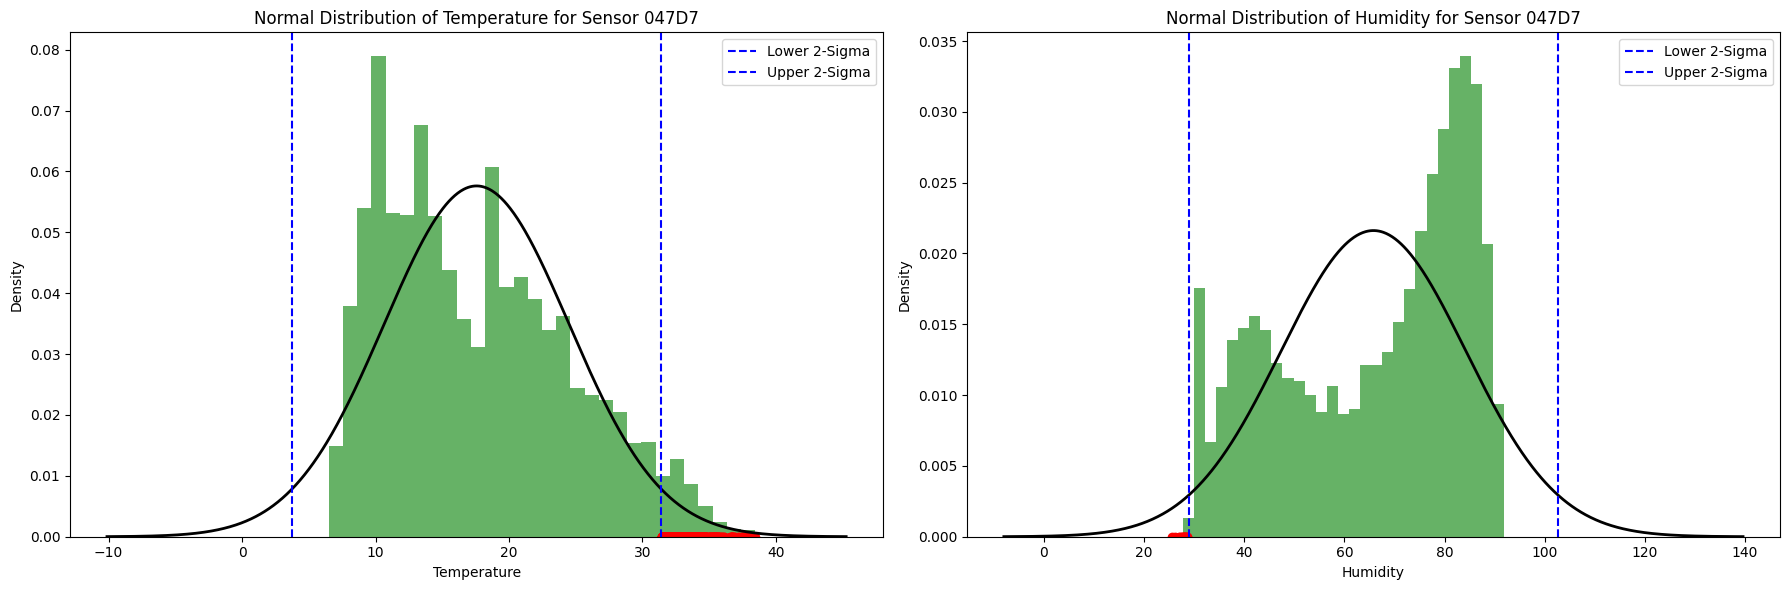

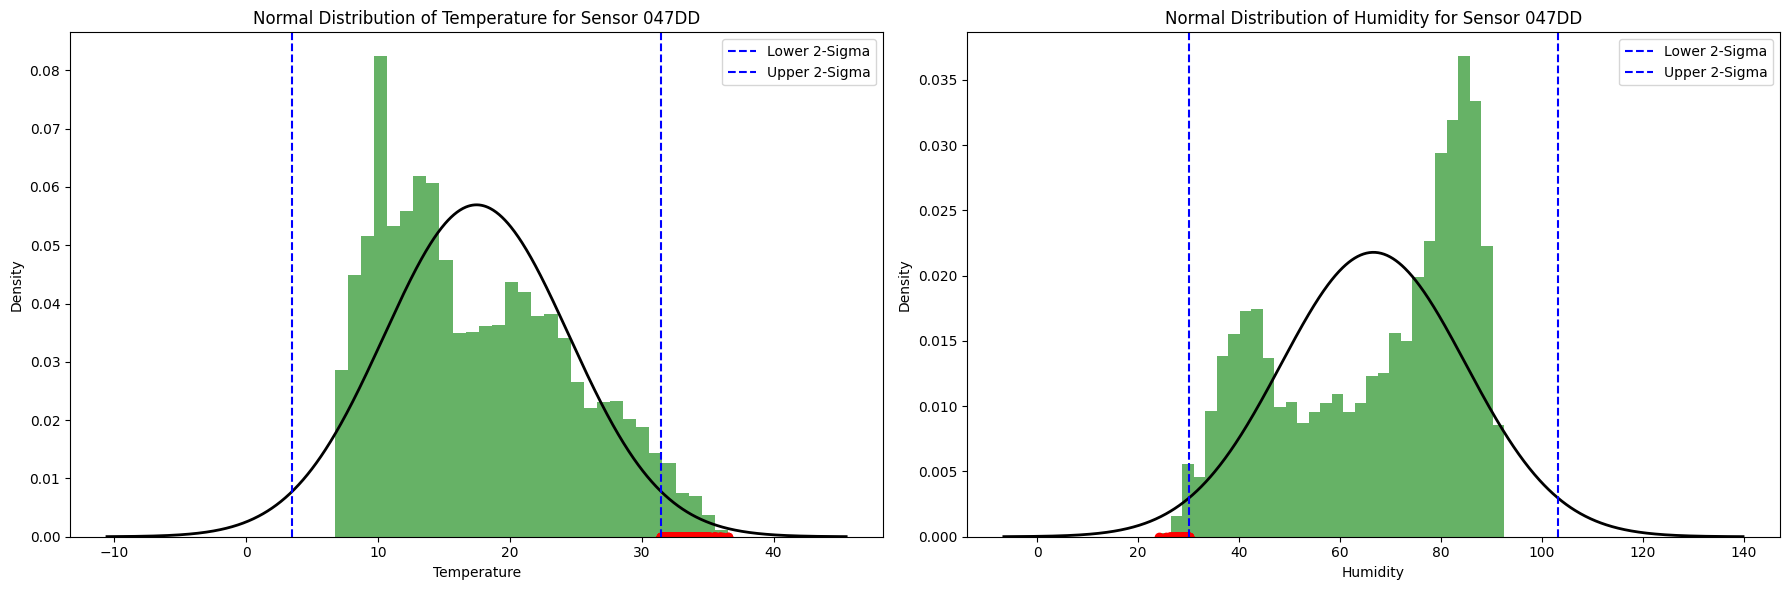

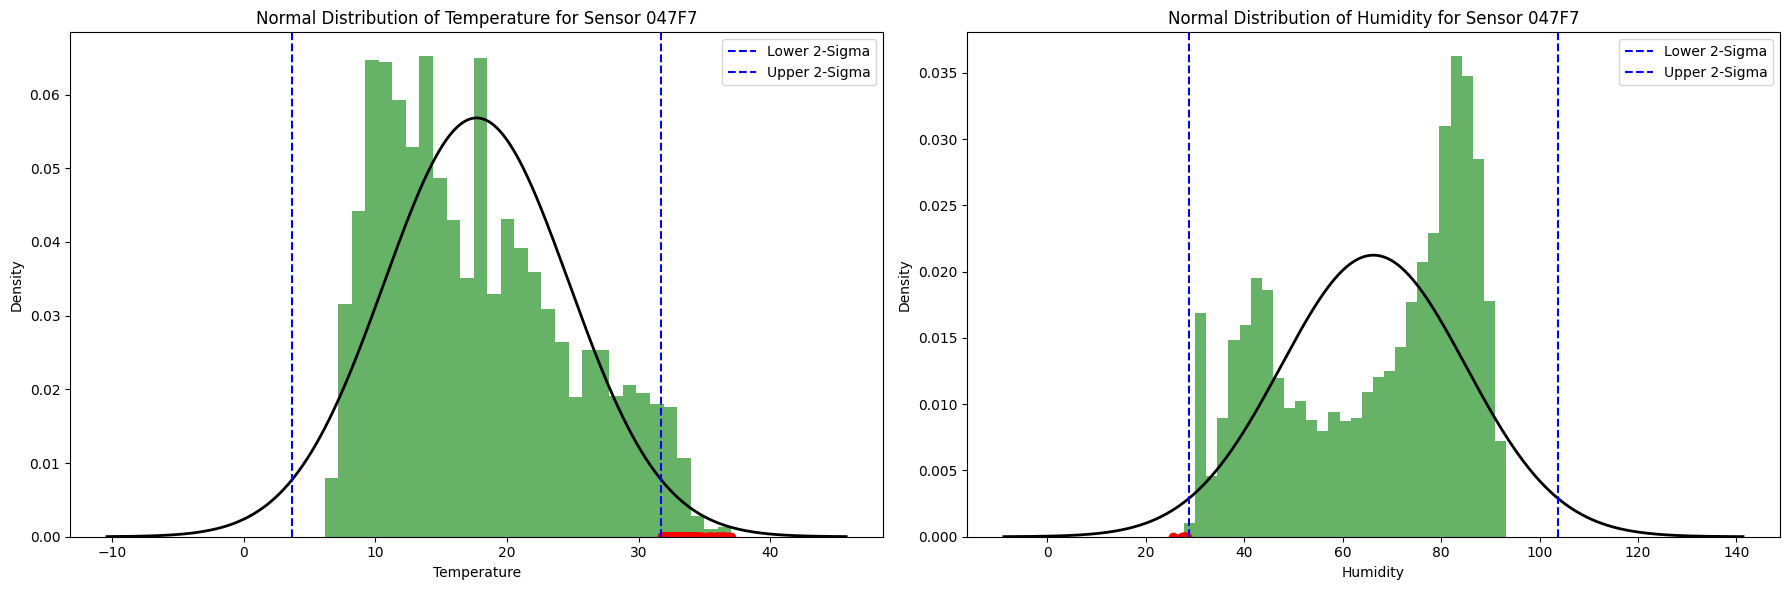

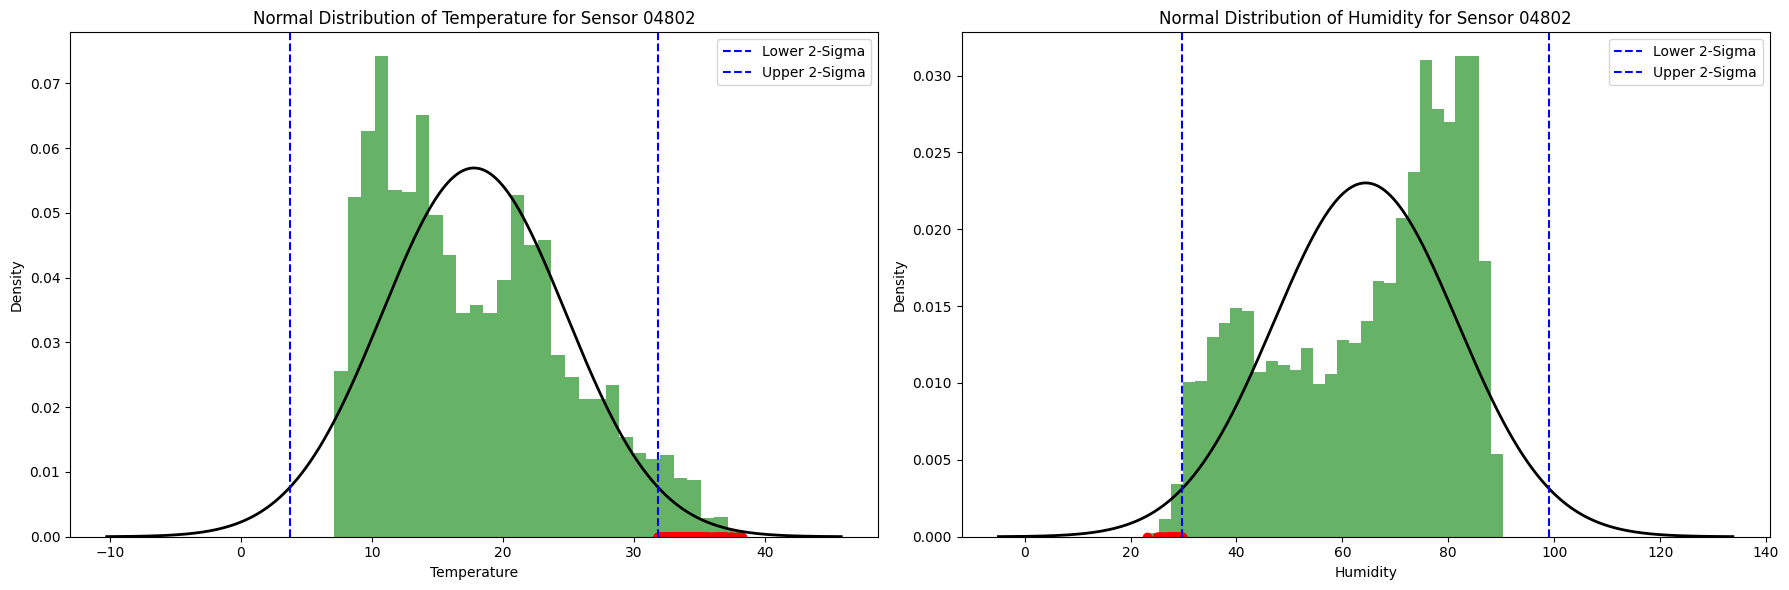

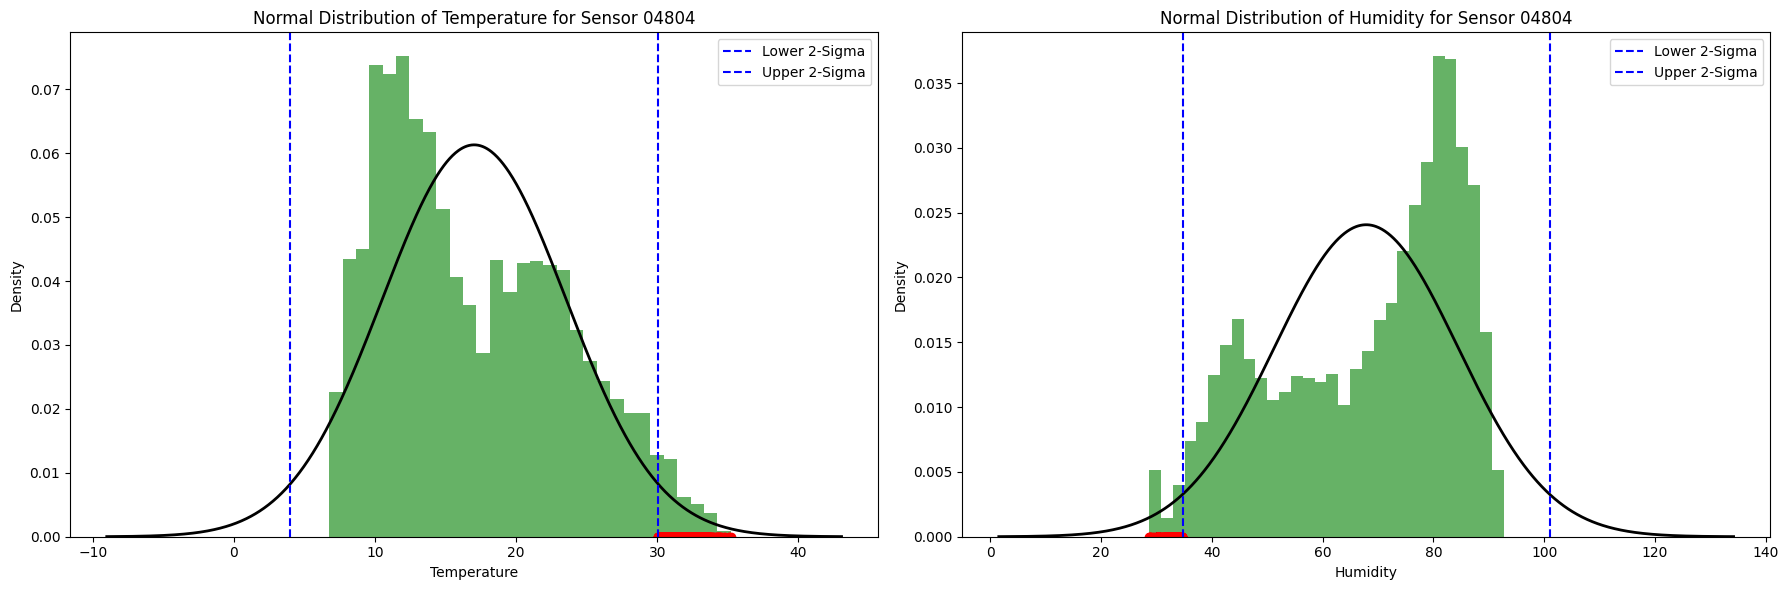

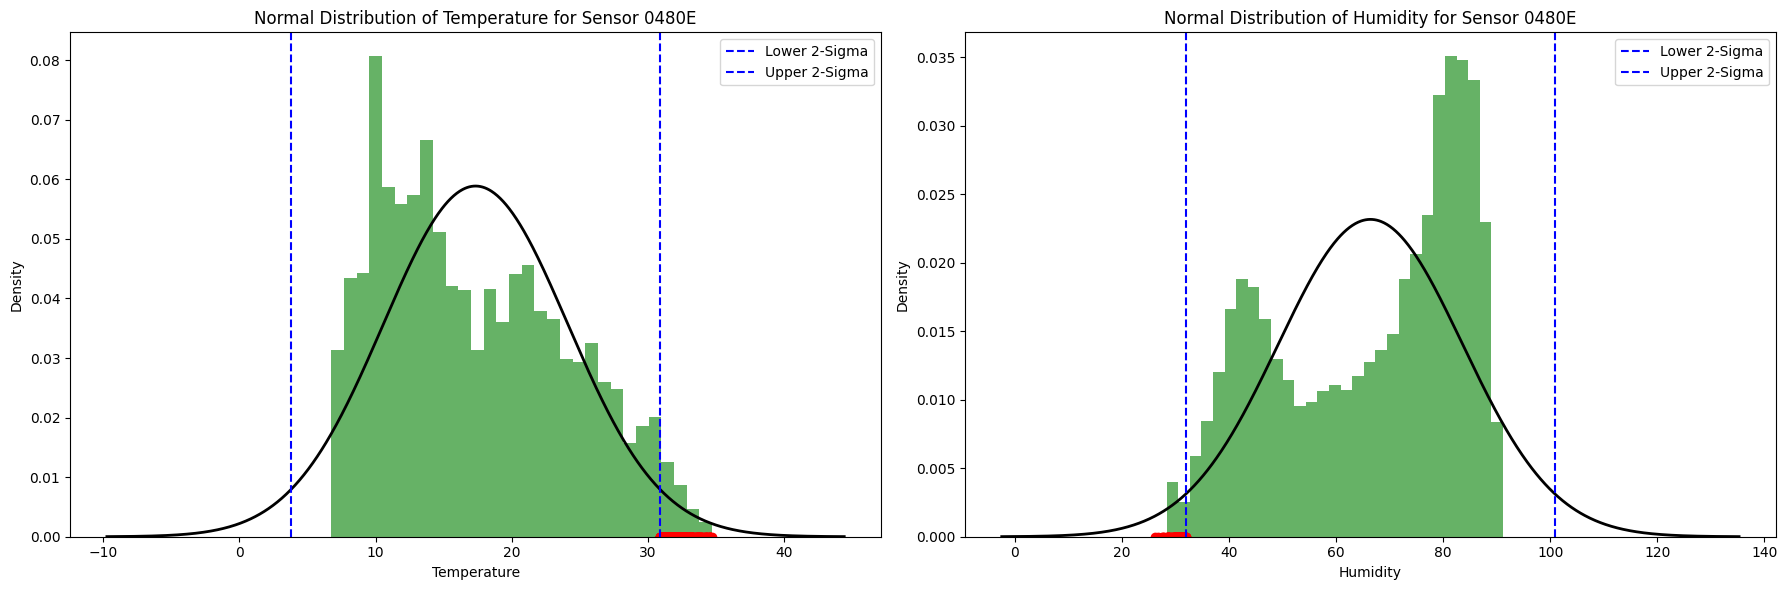

In [28]:
anomalies_list = []

for sensor_id, sensor_data in final_dataset.groupby('Sensor ID'):
    sensor_anomalies = detect_anomalies(sensor_data, sensor_id)
    anomalies_list.append(sensor_anomalies)

In [29]:
all_anomalies = pd.concat(anomalies_list)

In [30]:
non_anomalous_data = all_anomalies[(all_anomalies['Temperature_anomaly'] == 0) & (all_anomalies['Humidity_anomaly'] == 0)]

X_train = non_anomalous_data[['Temperature', 'Humidity']]
y_train_temp = non_anomalous_data['Temperature']
y_train_humidity = non_anomalous_data['Humidity']

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [34]:
mlp_temp = MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=500, random_state=42)
mlp_humidity = MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=500, random_state=42)

In [35]:
mlp_temp.fit(X_train_scaled, y_train_temp)

MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=500, random_state=42)

In [36]:
mlp_humidity.fit(X_train_scaled, y_train_humidity)

MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=500, random_state=42)

In [37]:
anomalies = all_anomalies[(all_anomalies['Temperature_anomaly'] == 1) & (all_anomalies['Humidity_anomaly'] == 1)].copy()

X_anomalies = anomalies[['Temperature', 'Humidity']]
X_anomalies_scaled = scaler.transform(X_anomalies)

In [38]:
anomalies['Temperature'] = np.round(mlp_temp.predict(X_anomalies_scaled), 2)
anomalies['Humidity'] = np.round(mlp_humidity.predict(X_anomalies_scaled), 2)

In [39]:
all_anomalies.update(anomalies[['Temperature', 'Humidity']])

In [40]:
anomalies.head()

Time  Temperature  Humidity Sensor ID      Sensor Name  \
9799  2024-05-20 13:18:34        33.92     28.88     0474D  0474D T/RH IP67   
9803  2024-05-20 13:38:33        32.62     28.28     0474D  0474D T/RH IP67   
17632 2024-04-30 12:18:06        31.57     33.98     04750  04750 T/RH IP67   
17634 2024-04-30 12:28:04        31.62     34.28     04750  04750 T/RH IP67   
17636 2024-04-30 12:38:06        32.22     33.78     04750  04750 T/RH IP67   

       Temperature_anomaly  Humidity_anomaly  
9799                     1                 1  
9803                     1                 1  
17632                    1                 1  
17634                    1                 1  
17636                    1                 1

In [41]:
final_processed_data = all_anomalies.copy()

In [42]:
final_processed_data.head()

Time  Temperature  Humidity Sensor ID      Sensor Name  \
0 2024-04-16 13:09:53        21.95      50.3     0474D  0474D T/RH IP67   
1 2024-04-16 13:14:52        22.50      34.7     0474D  0474D T/RH IP67   
2 2024-04-16 13:19:54        24.05      34.7     0474D  0474D T/RH IP67   
3 2024-04-16 13:24:53        24.25      34.7     0474D  0474D T/RH IP67   
4 2024-04-16 13:29:52        24.15      35.2     0474D  0474D T/RH IP67   

   Temperature_anomaly  Humidity_anomaly  
0                    0                 0  
1                    0                 0  
2                    0                 0  
3                    0                 0  
4                    0                 0